In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0, DenseNet121, InceptionV3
from tensorflow.keras.applications.mobilenet import preprocess_input
import tensorflow as tf
from keras_tuner import RandomSearch
import xgboost as xgb
import torch

In [6]:
# Ensure GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")
print(f"Number of available GPUs: {torch.cuda.device_count()}")

# Enable device-side assertions
os.environ['TORCH_USE_CUDA_DSA'] = "1"


Selected device: cuda
Number of available GPUs: 1


### Dataset Directory and Structure Verification

In [7]:
# Directory paths
dataset_dir = r"C:\users\749458\OneDrive - hull.ac.uk\Downloads\archive (2)\DATASET"
train_directory = r"C:\users\749458\OneDrive - hull.ac.uk\Downloads\archive (2)\DATASET\TRAIN"
test_directory = r"C:\users\749458\OneDrive - hull.ac.uk\Downloads\archive (2)\DATASET\TEST"

In [8]:
# Verify the directory structure
print("Training Directory Contents:", os.listdir(train_directory))
print("Test Directory Contents:", os.listdir(test_directory))

Training Directory Contents: ['O', 'R']
Test Directory Contents: ['O', 'R']


In [9]:
# Verify the directory structure
print("Training Directory Contents:", os.listdir(train_directory))
print("Test Directory Contents:", os.listdir(test_directory))

# Function to count and display the number of images in each directory
def count_images_in_directory(directory):
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            image_count = len(os.listdir(category_path))
            print(f"Category: {category} | Number of images: {image_count}")

# Count and display the number of images in the training directory
print("\nNumber of images per category in the Training Directory:")
count_images_in_directory(train_directory)

# Count and display the number of images in the test directory
print("\nNumber of images per category in the Test Directory:")
count_images_in_directory(test_directory)

Training Directory Contents: ['O', 'R']
Test Directory Contents: ['O', 'R']

Number of images per category in the Training Directory:
Category: O | Number of images: 12565
Category: R | Number of images: 9999

Number of images per category in the Test Directory:
Category: O | Number of images: 1401
Category: R | Number of images: 1112


- The above explained the structure of the dataset, the number of each images per categoory for both training and testing directory. The testing directory contains 12,565 images of organic and 9,999 images of recylable. While the testing category consists of 1,401 images of organic and 1,112 images of recylable. This shows that the training directory is slightly imbalance with more images in organic that recyclable. 

### DATA ENHANCEMENT

In [10]:
# Plot Random Images from the Dataset
def plot_random_images(dataset_dir, category, num_images=4):
    category_dir = os.path.join(dataset_dir, 'TRAIN', category)
    image_files = os.listdir(category_dir)
    random_images = random.sample(image_files, num_images)
    plt.figure(figsize=(8, 5))
    for i, image_name in enumerate(random_images):
        image_path = os.path.join(category_dir, image_name)
        image = Image.open(image_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(("Organic" if category == 'O' else "Recycle") + " Waste")
        plt.axis('off')
    plt.show()

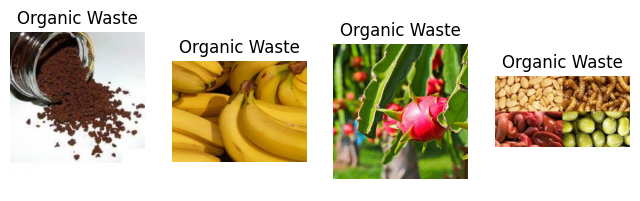

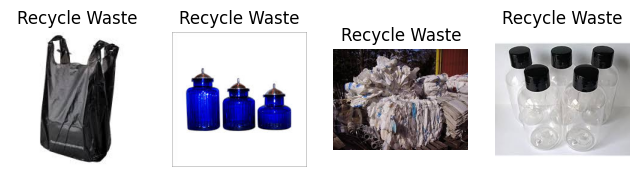

In [11]:
# Display random images for both categories
plot_random_images(dataset_dir, 'O', num_images=4)
plot_random_images(dataset_dir, 'R', num_images=4)

### Data Loading and Preprocessing

In [12]:
# Load Data and Prepare DataFrame
x_data = []
y_data = []

In [13]:
for category in glob(train_directory + '/*'):
    for file in tqdm(glob(category + '/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        img_array = cv2.resize(img_array, (150, 150))
        x_data.append(img_array)
        y_data.append(category.split("\\")[-1])

100%|█████████████████████████████████████████████████████████████████████████████| 9999/9999 [01:18<00:00, 127.21it/s]


In [15]:
df = pd.DataFrame({'image': x_data, 'label': y_data})

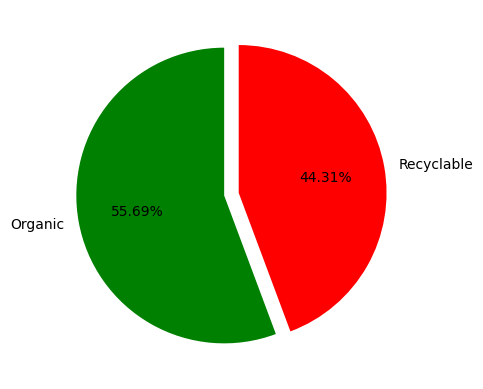

In [16]:
# Plot Data Distribution
colors = ['green', 'red']
plt.pie(df['label'].value_counts(), startangle=90, explode=[0.05, 0.05], autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors=colors, radius=1)
plt.show()

- The pie chart shows the distribution of the two categories, the Organic 55.69% and Recyclable 44.31%.

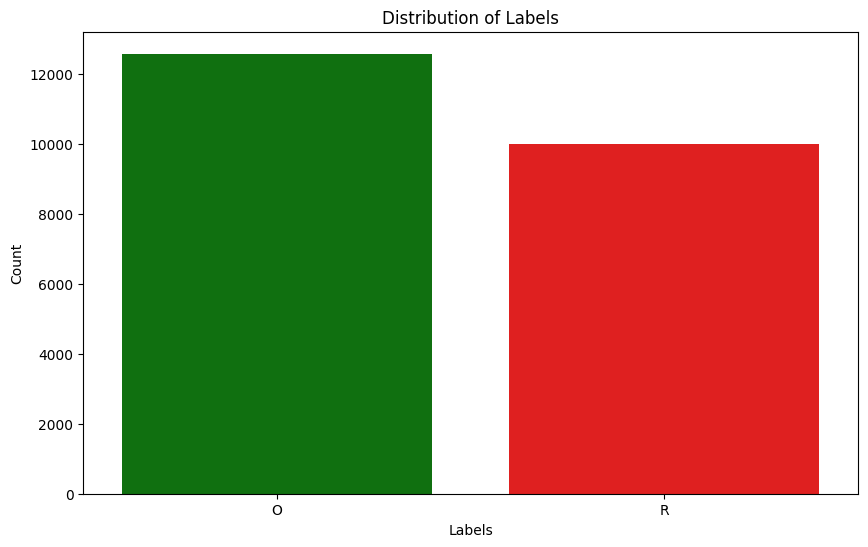

In [18]:
# Plot a bar chart of the label distribution
label_counts = df['label'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

### ADVANCED IMAGE PREPROCESSING

In [19]:
def advanced_preprocessing(image_array):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)
    return edges

In [20]:
# Apply advanced preprocessing to images
x_data_advanced = [advanced_preprocessing(img) for img in x_data]

In [21]:
# Convert to numpy array and reshape for input to model
x_data_advanced = np.array(x_data_advanced)
x_data_advanced = x_data_advanced.reshape(x_data_advanced.shape[0], -1) / 255.0

### DATA PREPROCESSING

In [22]:
def preprocess_images(x_data):
    x_data = np.array(x_data) / 255.0
    x_data = x_data.reshape(x_data.shape[0], 150, 150, 3)
    return x_data

In [23]:
# Preprocess the images
x_data_processed = preprocess_images(x_data)

In [24]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_data_processed, y_data, test_size=0.2, random_state=42)

In [25]:
# Convert labels to binary (0 for Organic, 1 for Recyclable)
y_train = np.array([1 if label == 'R' else 0 for label in y_train])
y_val = np.array([1 if label == 'R' else 0 for label in y_val])

In [26]:
# Prepare Image Data Generators
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

validation_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_data_generator.flow(
    X_train, y_train, batch_size=32, shuffle=True
)

validation_generator = validation_data_generator.flow(
    X_val, y_val, batch_size=32, shuffle=False
)

### TRAIN CNN MODEL

In [26]:
# Build and compile the CNN model
def build_cnn(input_shape=(150, 150, 3), dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(rate=dropout_rate),
        Dense(units=1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = build_cnn()

In [27]:
# Train the CNN model without EarlyStopping
history = cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Plotting training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    plt.show()

Epoch 1/10
565/565 [==============================] - 1291s 2s/step - loss: 0.6942 - accuracy: 0.5526 - val_loss: 0.6864 - val_accuracy: 0.5657
Epoch 2/10
565/565 [==============================] - 1162s 2s/step - loss: 0.6877 - accuracy: 0.5547 - val_loss: 0.6855 - val_accuracy: 0.5657
Epoch 3/10
565/565 [==============================] - 1155s 2s/step - loss: 0.6876 - accuracy: 0.5547 - val_loss: 0.6851 - val_accuracy: 0.5657
Epoch 4/10
565/565 [==============================] - 1211s 2s/step - loss: 0.6874 - accuracy: 0.5547 - val_loss: 0.6846 - val_accuracy: 0.5657
Epoch 5/10
565/565 [==============================] - 1213s 2s/step - loss: 0.6873 - accuracy: 0.5547 - val_loss: 0.6847 - val_accuracy: 0.5657
Epoch 6/10
565/565 [==============================] - 1202s 2s/step - loss: 0.6873 - accuracy: 0.5547 - val_loss: 0.6851 - val_accuracy: 0.5657
Epoch 7/10
565/565 [==============================] - 1209s 2s/step - loss: 0.6873 - accuracy: 0.5547 - val_loss: 0.6849 - val_accuracy:

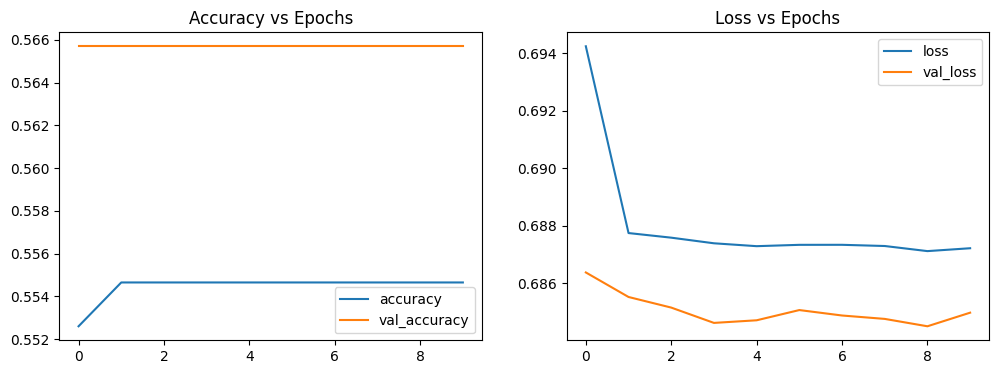

C:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
plot_training_history(history)

# Save the model
cnn_model.save('cnn1_model.h5')


- From the above we can suggests that the is not improving therefore there is an underfitting.Both the training and validation accuracy are almost constant and the loss is decreasing slowly with little improvement.

### Evaluate the CNN Model

Found 2513 images belonging to 2 classes.
79/79 [==============================] - 26s 332ms/step
              precision    recall  f1-score   support

           O       0.81      0.64      0.72      1401
           R       0.64      0.80      0.71      1112

    accuracy                           0.72      2513
   macro avg       0.72      0.72      0.72      2513
weighted avg       0.73      0.72      0.72      2513



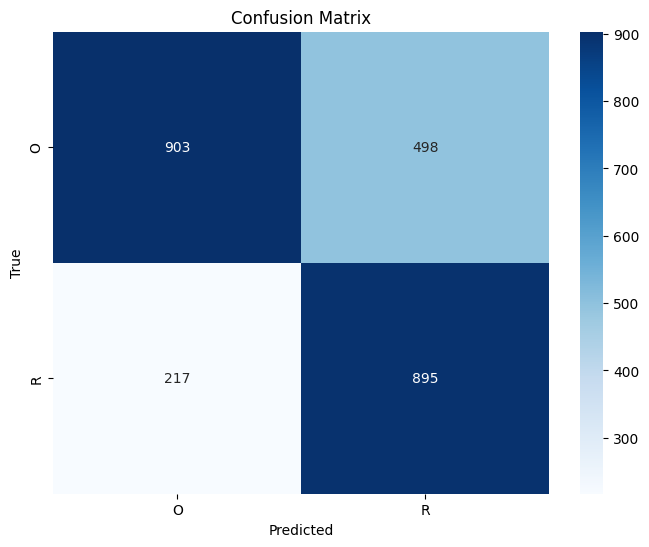

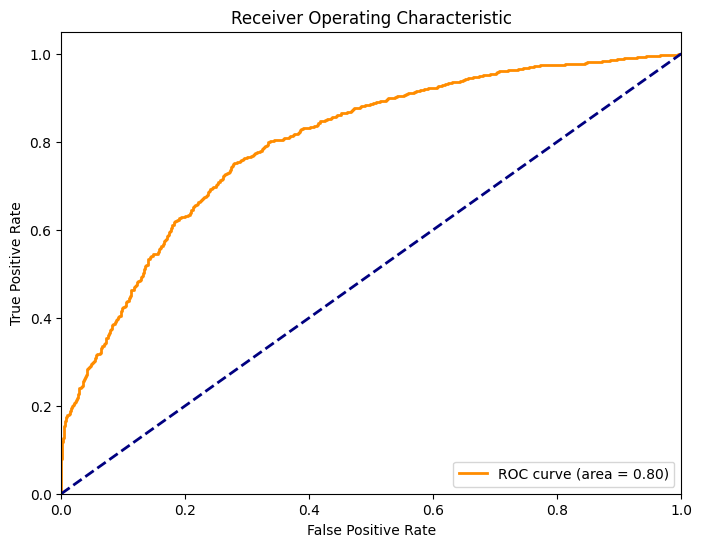

Test Accuracy: 0.72


In [35]:
# Prepare test data generator
test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_data_generator.flow_from_directory(
    test_directory,
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

# Evaluate the CNN model
def evaluate_cnn_model(model, generator, steps_per_epoch):
    # Generate predictions
    predictions = model.predict(generator, steps=steps_per_epoch)
    predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Classification Report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_classes, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Return accuracy
    return accuracy_score(true_classes, predicted_classes)

# Call the evaluation function
cnn_accuracy = evaluate_cnn_model(cnn_model, test_generator, test_steps_per_epoch)
print(f"Test Accuracy: {cnn_accuracy:.2f}")


- The model's overall accuracy is 72%, Organic has a precision of 81% which shows it was able correctly identifies 81% of Organic wastes, though it has a lower recall of 64% showing that some organic were mispecified. On the other hand Recyclable has 80% recall indicating the model was able to identify correctly most Recyclable wastes, however it has a lower precision of 64% showing more false positives.
- 
Moreover, according to the confusion matrix above 903 were correctly classified as "Orgainic" out of 1,401 Organic wastes and 498 were incorrectly classified as Recyclable. While on the other hand out of 1,112 Recyclable, 895 were correctly classifed as "Recyclable" while 217 were incorrectly classified as "Organic".- 

Finally, the Reciever Operating Characteristic (ROC) and Area under the Curve (AUC) of 80% suggests that the model is an effective classifier that achieve an excellent performance in classitying the two classes organic and recyclable wastes. This indicates a good model performance.The Test accuarcy shows that 72% of the test data were correctly classified.

### TRAIN TRADITIONAL ML MODELS WITH PCA

In [29]:
# Reload data for grayscale conversion
def load_and_preprocess_data(train_directory, target_size=(32, 32)):
    x_data = []
    y_data = []
    for category in glob(train_directory + '/*'):
        for file in glob(category + '/*'):
            img_array = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            img_array = cv2.resize(img_array, target_size)
            x_data.append(img_array)
            y_data.append(category.split("\\")[-1])

    x_data = np.array(x_data)
    y_data = np.array([1 if label == 'R' else 0 for label in y_data])
    return x_data, y_data

In [30]:
# Use a smaller size to reduce feature count
x_data, y_data = load_and_preprocess_data(train_directory, target_size=(15, 15))

In [31]:
# Flatten images for model input
X_train_flat, X_val_flat, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
X_train_flat = X_train_flat.reshape(X_train_flat.shape[0], -1) / 255.0
X_val_flat = X_val_flat.reshape(X_val_flat.shape[0], -1) / 255.0

### PCA for dimensionality reduction

In [32]:
# Adjust n_components to be less than or equal to min(n_samples, n_features)
n_components = min(X_train_flat.shape[0], X_train_flat.shape[1], 15)  # Ensure it doesn't exceed samples or features
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

In [33]:
print(f"PCA applied with {n_components} components.")

PCA applied with 15 components.


In [34]:
# StandardScaler for non-CNN models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)

In [35]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Organic', 'Recyclable'], yticklabels=['Organic', 'Recyclable'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [36]:
model_accuracies = {}

In [37]:
# Train Random Forest with PCA
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_pca, y_train)
rf_predictions = rf_model.predict(X_val_pca)

In [38]:
print("Random Forest with PCA")
print(classification_report(y_val, rf_predictions, target_names=['Organic', 'Recyclable']))

Random Forest with PCA
              precision    recall  f1-score   support

     Organic       0.70      0.84      0.76      2553
  Recyclable       0.71      0.53      0.61      1960

    accuracy                           0.70      4513
   macro avg       0.70      0.68      0.68      4513
weighted avg       0.70      0.70      0.69      4513



- According to the findings of the classification report, the model overall accuracy is 70%  meaning 70% of the total images were correctly classified.
- The model has a balanced performance in terms of the following  metrics, precision, reall, and f1-score.

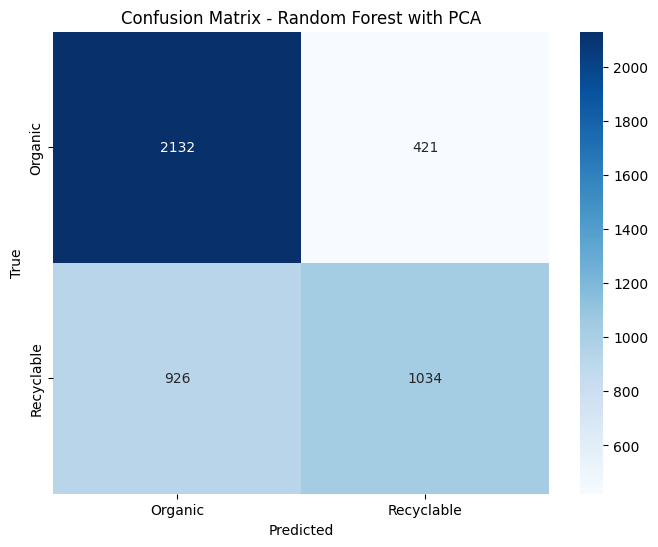

In [39]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_val, rf_predictions)
plot_confusion_matrix(cm_rf, 'Confusion Matrix - Random Forest with PCA')

# Store accuracy
model_accuracies['Random Forest with PCA'] = accuracy_score(y_val, rf_predictions)

- According to the above confusion matrix the model was able to predict 2132 instances as "Organic" and 421 instances were incorrectly as "Recyclable " when they were actually "Organic". Also, 926 instances  were incorrectly predicted as "Recyclable  while 1034 samples were coorectly predicted as "Recyclable"

In [40]:
# Train AdaBoost with PCA
adaboost_model = AdaBoostClassifier(random_state=42)
adaboost_model.fit(X_train_pca, y_train)
adaboost_predictions = adaboost_model.predict(X_val_pca)

In [41]:
print("AdaBoost with PCA")
print(classification_report(y_val, adaboost_predictions, target_names=['Organic', 'Recyclable']))

AdaBoost with PCA
              precision    recall  f1-score   support

     Organic       0.69      0.79      0.73      2553
  Recyclable       0.66      0.53      0.59      1960

    accuracy                           0.68      4513
   macro avg       0.67      0.66      0.66      4513
weighted avg       0.67      0.68      0.67      4513



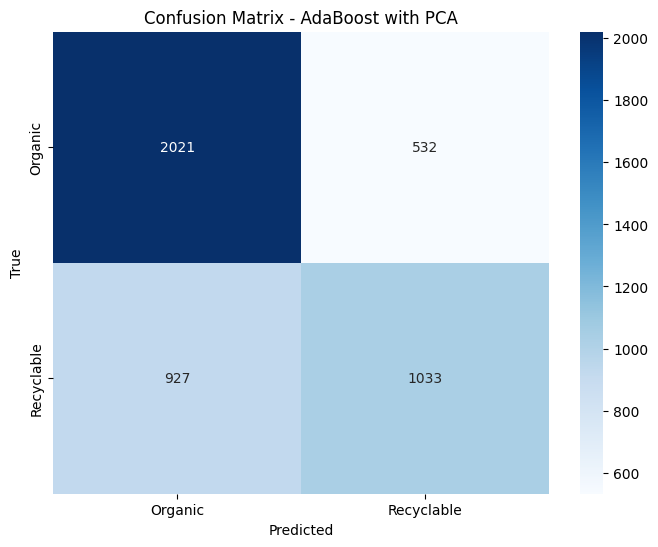

In [42]:
# Confusion Matrix for AdaBoost
cm_adaboost = confusion_matrix(y_val, adaboost_predictions)
plot_confusion_matrix(cm_adaboost, 'Confusion Matrix - AdaBoost with PCA')

# Store accuracy
model_accuracies['AdaBoost with PCA'] = accuracy_score(y_val, adaboost_predictions)

- According to the above confusion matrix the model was able to predict 2121 instances as "Organic" and 532 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 927 instances  were incorrectly predicted as "Recyclable  while 1033 samples were correctly predicted as "Recyclable"

In [43]:
# Train XGBoost with PCA
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_pca, y_train)
xgb_predictions = xgb_model.predict(X_val_pca)

C:\Users\749458\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [44]:
print("XGBoost with PCA")
print(classification_report(y_val, xgb_predictions, target_names=['Organic', 'Recyclable']))

XGBoost with PCA
              precision    recall  f1-score   support

     Organic       0.69      0.77      0.73      2553
  Recyclable       0.65      0.56      0.60      1960

    accuracy                           0.68      4513
   macro avg       0.67      0.66      0.67      4513
weighted avg       0.68      0.68      0.67      4513



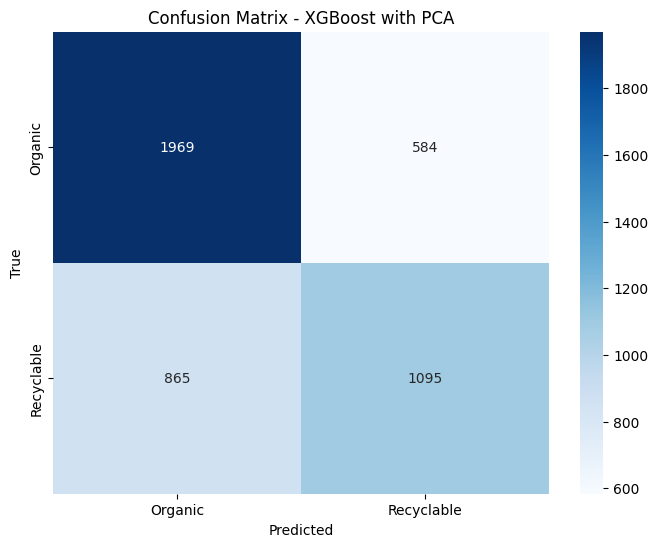

In [45]:
# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_val, xgb_predictions)
plot_confusion_matrix(cm_xgb, 'Confusion Matrix - XGBoost with PCA')

# Store accuracy
model_accuracies['XGBoost with PCA'] = accuracy_score(y_val, xgb_predictions)

- According to the above confusion matrix the model was able to predict 1969 instances as "Organic" and 584 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 865 instances  were incorrectly predicted as "Recyclable  while 1095 samples were correctly predicted as "Recyclable"

In [46]:
# Train Naive Bayes with PCA
nb_model = GaussianNB()
nb_model.fit(X_train_pca, y_train)
nb_predictions = nb_model.predict(X_val_pca)

In [47]:
print("Naive Bayes with PCA")
print(classification_report(y_val, nb_predictions, target_names=['Organic', 'Recyclable']))

Naive Bayes with PCA
              precision    recall  f1-score   support

     Organic       0.70      0.71      0.71      2553
  Recyclable       0.62      0.60      0.61      1960

    accuracy                           0.66      4513
   macro avg       0.66      0.66      0.66      4513
weighted avg       0.66      0.66      0.66      4513



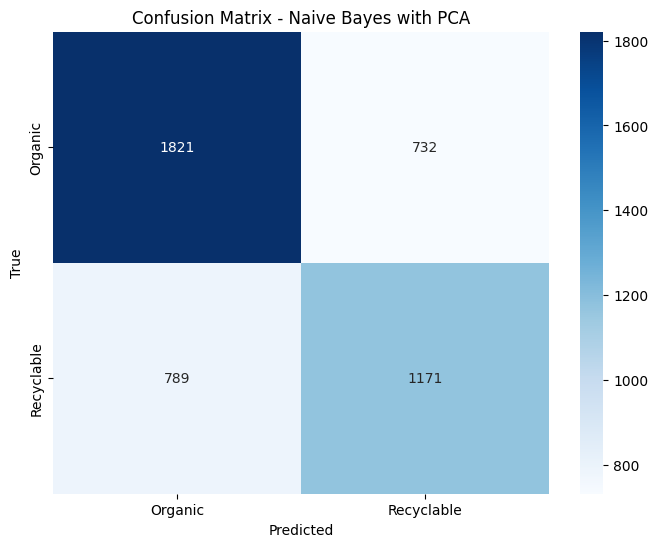

In [48]:
# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_val, nb_predictions)
plot_confusion_matrix(cm_nb, 'Confusion Matrix - Naive Bayes with PCA')

# Store accuracy
model_accuracies['Naive Bayes with PCA'] = accuracy_score(y_val, nb_predictions)


- According to the above confusion matrix the model was able to predict 1821 instances as "Organic" and 732 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 789 instances  were incorrectly predicted as "Recyclable  while 1171 samples were correctly predicted as "Recyclable"

In [49]:
# Train SVM with PCA
svm_model = SVC(probability=True)
svm_model.fit(X_train_pca, y_train)
svm_predictions = svm_model.predict(X_val_pca)

In [50]:
print("SVM with PCA")
print(classification_report(y_val, svm_predictions, target_names=['Organic', 'Recyclable']))

SVM with PCA
              precision    recall  f1-score   support

     Organic       0.70      0.82      0.75      2553
  Recyclable       0.69      0.53      0.60      1960

    accuracy                           0.70      4513
   macro avg       0.70      0.68      0.68      4513
weighted avg       0.70      0.70      0.69      4513



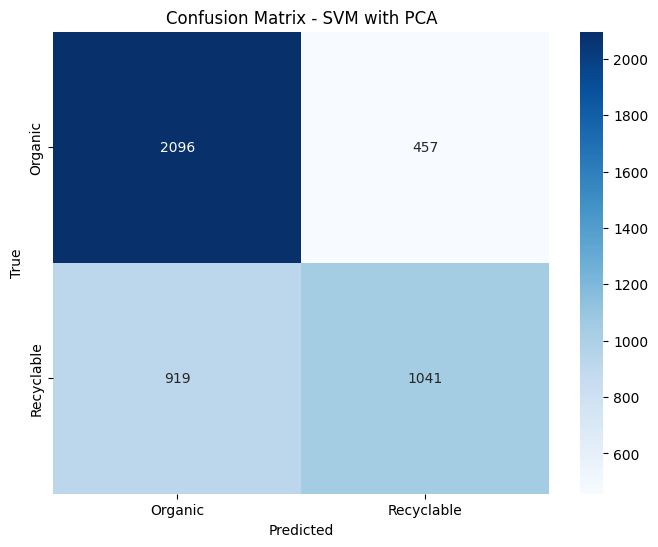

In [51]:
# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_val, svm_predictions)
plot_confusion_matrix(cm_svm, 'Confusion Matrix - SVM with PCA')

# Store accuracy
model_accuracies['SVM with PCA'] = accuracy_score(y_val, svm_predictions)


- According to the above confusion matrix the model was able to predict 2096 instances as "Organic" and 457 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 919 instances  were incorrectly predicted as "Recyclable  while 1041 samples were correctly predicted as "Recyclable".

In [52]:
# Train Logistic Regression with PCA
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train_pca, y_train)
lr_predictions = lr_model.predict(X_val_pca)

In [53]:
print("Logistic Regression with PCA")
print(classification_report(y_val, lr_predictions, target_names=['Organic', 'Recyclable']))

Logistic Regression with PCA
              precision    recall  f1-score   support

     Organic       0.68      0.76      0.72      2553
  Recyclable       0.63      0.54      0.58      1960

    accuracy                           0.66      4513
   macro avg       0.66      0.65      0.65      4513
weighted avg       0.66      0.66      0.66      4513



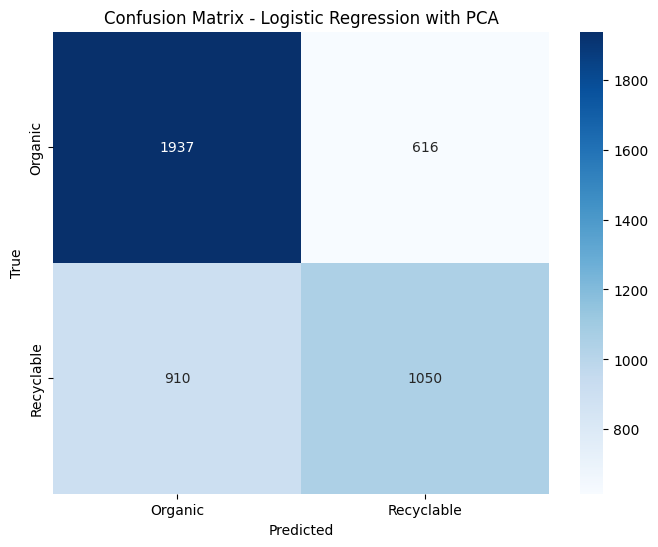

In [54]:
# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_val, lr_predictions)
plot_confusion_matrix(cm_lr, 'Confusion Matrix - Logistic Regression with PCA')

# Store accuracy
model_accuracies['Logistic Regression with PCA'] = accuracy_score(y_val, lr_predictions)

- According to the above confusion matrix the model was able to predict 1937 instances correctly as "Organic" and 6161 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 910 instances  were incorrectly predicted as "Recyclable  while 1050 samples were correctly predicted as "Recyclable".

### TRAIN TRADITIONAL ML MODELS WITHOUT PCA

### RANDOM FOREST

In [55]:
# Train Random Forest without PCA
rf_model_no_pca = RandomForestClassifier(random_state=42)
rf_model_no_pca.fit(X_train_scaled, y_train)
rf_predictions_no_pca = rf_model_no_pca.predict(X_val_scaled)

In [56]:
print("Random Forest")
print(classification_report(y_val, rf_predictions_no_pca, target_names=['Organic', 'Recyclable']))

Random Forest
              precision    recall  f1-score   support

     Organic       0.70      0.84      0.77      2553
  Recyclable       0.72      0.54      0.62      1960

    accuracy                           0.71      4513
   macro avg       0.71      0.69      0.69      4513
weighted avg       0.71      0.71      0.70      4513



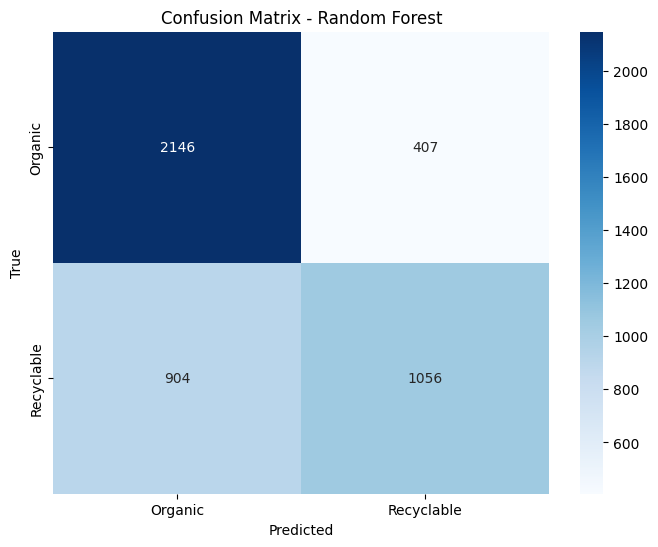

In [57]:
# Confusion Matrix for Random Forest
cm_rf_no_pca = confusion_matrix(y_val, rf_predictions_no_pca)
plot_confusion_matrix(cm_rf_no_pca, 'Confusion Matrix - Random Forest')

# Store accuracy
model_accuracies['Random Forest Without PCA'] = accuracy_score(y_val, rf_predictions_no_pca)


- According to the above confusion matrix the model was able to predict 2146 instances as "Organic" and 407 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 904  instances  were incorrectly predicted as "Recyclable  while 1056 samples were correctly predicted as "Recyclable".

### Adaptive Boosting (AdaBoost)

In [58]:
# Train AdaBoost without PCA
adaboost_model_no_pca = AdaBoostClassifier(random_state=42)
adaboost_model_no_pca.fit(X_train_scaled, y_train)
adaboost_predictions_no_pca = adaboost_model_no_pca.predict(X_val_scaled)

In [59]:
print("AdaBoost")
print(classification_report(y_val, adaboost_predictions_no_pca, target_names=['Organic', 'Recyclable']))

AdaBoost
              precision    recall  f1-score   support

     Organic       0.68      0.76      0.72      2553
  Recyclable       0.63      0.54      0.58      1960

    accuracy                           0.66      4513
   macro avg       0.66      0.65      0.65      4513
weighted avg       0.66      0.66      0.66      4513



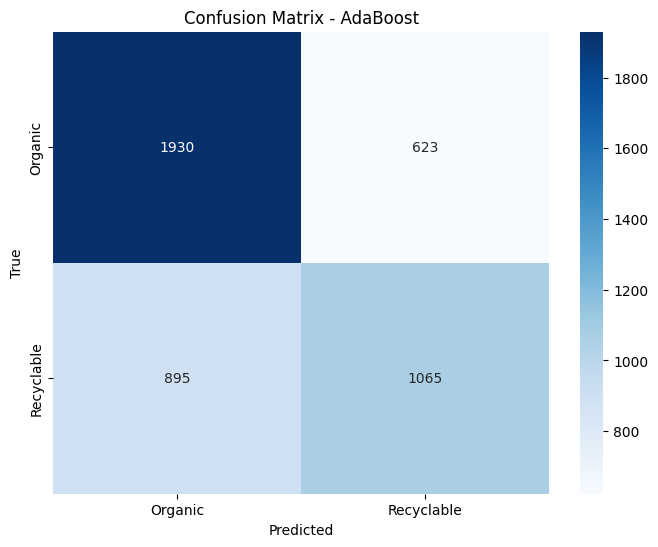

In [60]:
# Confusion Matrix for AdaBoost
cm_adaboost_no_pca = confusion_matrix(y_val, adaboost_predictions_no_pca)
plot_confusion_matrix(cm_adaboost_no_pca, 'Confusion Matrix - AdaBoost')

# Store accuracy
model_accuracies['AdaBoost without PCA'] = accuracy_score(y_val, adaboost_predictions_no_pca)

- According to the above confusion matrix the model was able to predict 1930 instances as "Organic" and 623 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 895 instances  were incorrectly predicted as "Recyclable  while 1065 samples were correctly predicted as "Recyclable".

### XGBOOST

In [61]:
# Train XGBoost without PCA
xgb_model_no_pca = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model_no_pca.fit(X_train_scaled, y_train)
xgb_predictions_no_pca = xgb_model_no_pca.predict(X_val_scaled)

C:\Users\749458\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:00:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [62]:
print("XGBoost")
print(classification_report(y_val, xgb_predictions_no_pca, target_names=['Organic', 'Recyclable']))

XGBoost
              precision    recall  f1-score   support

     Organic       0.72      0.80      0.76      2553
  Recyclable       0.69      0.60      0.64      1960

    accuracy                           0.71      4513
   macro avg       0.71      0.70      0.70      4513
weighted avg       0.71      0.71      0.71      4513



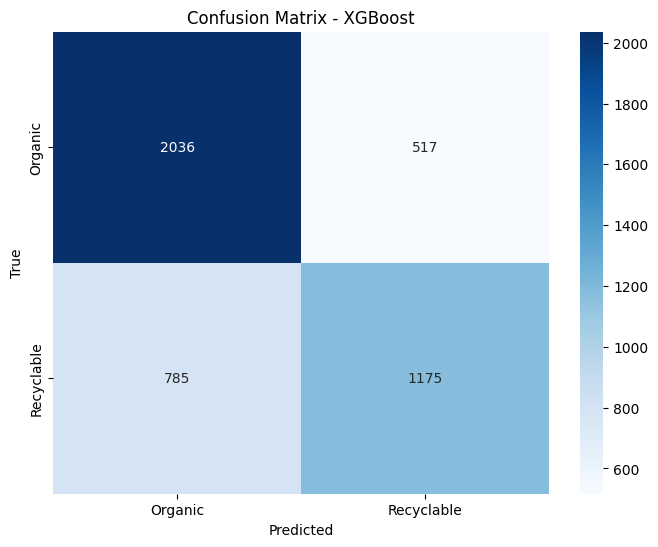

In [63]:
# Confusion Matrix for XGBoost
cm_xgb_no_pca = confusion_matrix(y_val, xgb_predictions_no_pca)
plot_confusion_matrix(cm_xgb_no_pca, 'Confusion Matrix - XGBoost')

# Store accuracy
model_accuracies['XGBoost Without PCA'] = accuracy_score(y_val, xgb_predictions_no_pca)

- According to the above confusion matrix the model was able to predict 2036 instances correctly as "Organic" and 517 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 785 instances  were incorrectly predicted as "Recyclable  while 1175 samples were correctly predicted as "Recyclable".

### NAIVE BAYES

In [64]:
# Train Naive Bayes without PCA
nb_model_no_pca = GaussianNB()
nb_model_no_pca.fit(X_train_scaled, y_train)
nb_predictions_no_pca = nb_model_no_pca.predict(X_val_scaled)

In [65]:
print("Naive Bayes")
print(classification_report(y_val, nb_predictions_no_pca, target_names=['Organic', 'Recyclable']))

Naive Bayes
              precision    recall  f1-score   support

     Organic       0.70      0.63      0.67      2553
  Recyclable       0.58      0.65      0.61      1960

    accuracy                           0.64      4513
   macro avg       0.64      0.64      0.64      4513
weighted avg       0.65      0.64      0.64      4513



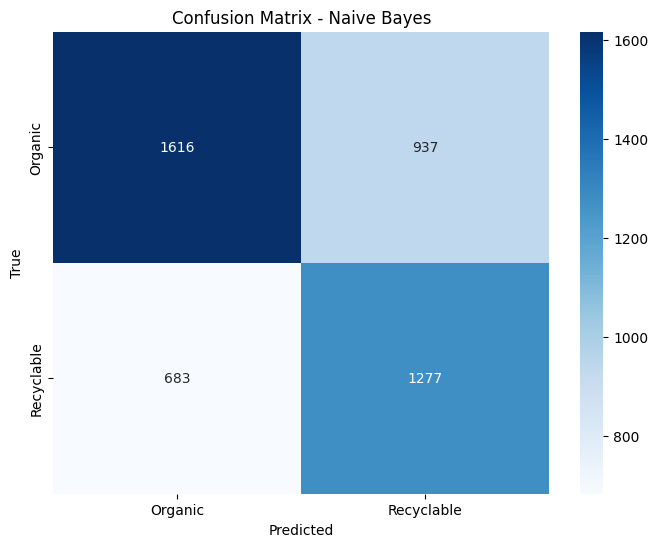

In [66]:
# Confusion Matrix for Naive Bayes
cm_nb_no_pca = confusion_matrix(y_val, nb_predictions_no_pca)
plot_confusion_matrix(cm_nb_no_pca, 'Confusion Matrix - Naive Bayes')

# Store accuracy
model_accuracies['Naive Bayes Without PCA'] = accuracy_score(y_val, nb_predictions_no_pca)

- According to the above confusion matrix the model was able to predict 1616 instances correctly as "Organic" and 937 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 683 instances  were incorrectly predicted as "Recyclable  while 1277 samples were correctly predicted as "Recyclable".

### SUPPORT VECTOR MACHINES

In [67]:
# Train SVM without PCA
svm_model_no_pca = SVC(kernel='linear', random_state=42)
svm_model_no_pca.fit(X_train_scaled, y_train)
svm_predictions_no_pca = svm_model_no_pca.predict(X_val_scaled)

In [68]:
print("SVM")
print(classification_report(y_val, svm_predictions_no_pca, target_names=['Organic', 'Recyclable']))

SVM
              precision    recall  f1-score   support

     Organic       0.68      0.76      0.72      2553
  Recyclable       0.63      0.53      0.58      1960

    accuracy                           0.66      4513
   macro avg       0.65      0.64      0.65      4513
weighted avg       0.66      0.66      0.65      4513



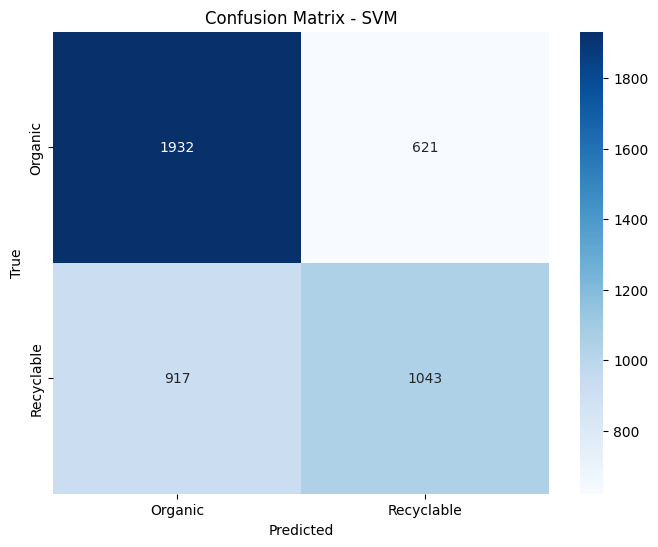

In [69]:
# Confusion Matrix for SVM
cm_svm_no_pca = confusion_matrix(y_val, svm_predictions_no_pca)
plot_confusion_matrix(cm_svm_no_pca, 'Confusion Matrix - SVM')

# Store accuracy
model_accuracies['SVM Without PCA'] = accuracy_score(y_val, svm_predictions_no_pca)

- According to the above confusion matrix the model was able to predict 1932 instances correctly as "Organic" and 621 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 917 instances  were incorrectly predicted as "Recyclable  while 1043 samples were correctly predicted as "Recyclable".

### LOGISTIC REGRESSION

In [70]:
# Train Logistic Regression without PCA
lr_model_no_pca = LogisticRegression(max_iter=500, random_state=42)
lr_model_no_pca.fit(X_train_scaled, y_train)
lr_predictions_no_pca = lr_model_no_pca.predict(X_val_scaled)

In [71]:
print("Logistic Regression")
print(classification_report(y_val, lr_predictions_no_pca, target_names=['Organic', 'Recyclable']))

Logistic Regression
              precision    recall  f1-score   support

     Organic       0.68      0.74      0.71      2553
  Recyclable       0.62      0.54      0.58      1960

    accuracy                           0.66      4513
   macro avg       0.65      0.64      0.65      4513
weighted avg       0.65      0.66      0.65      4513



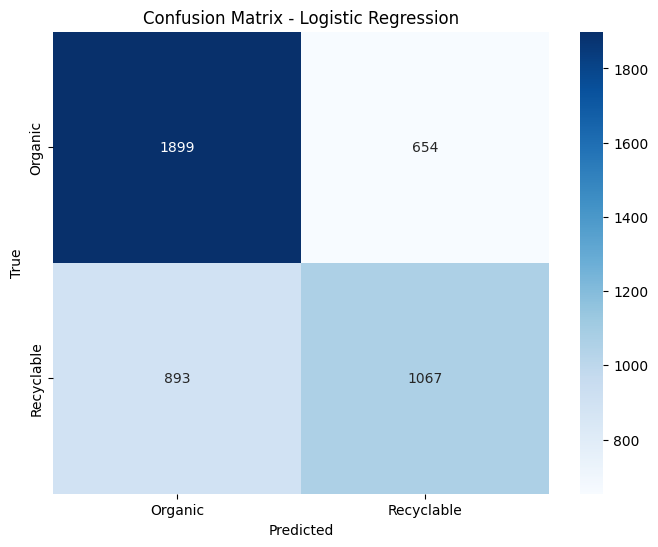

In [72]:
# Confusion Matrix for Logistic Regression
cm_lr_no_pca = confusion_matrix(y_val, lr_predictions_no_pca)
plot_confusion_matrix(cm_lr_no_pca, 'Confusion Matrix - Logistic Regression')

# Store accuracy
model_accuracies['Logistic Regression Withoout PCA'] = accuracy_score(y_val, lr_predictions_no_pca)

- According to the above confusion matrix the model was able to predict 1899 instances correctly as "Organic" and 654 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 893 instances  were incorrectly predicted as "Recyclable  while 1067 samples were correctly predicted as "Recyclable".

### TRANSFER LEARNING MODELS

In [73]:
# Data preprocessing for transfer learning models
train_generator_vgg16 = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    train_directory,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=16,  
    shuffle=True
)

validation_generator_vgg16 = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    train_directory,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=16,  # Reduced batch size
    shuffle=True
)

test_generator_vgg16 = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    test_directory,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=16,  # Reduced batch size
    shuffle=False
)

Found 22564 images belonging to 2 classes.
Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [74]:
# Function to train and evaluate a transfer learning model
def train_and_evaluate_transfer_learning_model(base_model, model_name, train_generator, validation_generator, test_generator):
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(train_generator, epochs=5, validation_data=validation_generator, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

    # Save the model
    model.save(f'{model_name}_transfer_learning_model.h5')

    # Plot training history
    plot_training_history(history)

    # Evaluate the model
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
    predictions = model.predict(test_generator, steps=test_steps_per_epoch)
    predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f"Classification Report - {model_name}")
    print(report)

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Return accuracy
    return accuracy_score(true_classes, predicted_classes)

###  VGG16

Epoch 1/5
1411/1411 [==============================] - 11041s 8s/step - loss: 0.2758 - accuracy: 0.8870 - val_loss: 0.2227 - val_accuracy: 0.9120
Epoch 2/5
1411/1411 [==============================] - 10798s 8s/step - loss: 0.2236 - accuracy: 0.9105 - val_loss: 0.2059 - val_accuracy: 0.9192
Epoch 3/5
1411/1411 [==============================] - 10760s 8s/step - loss: 0.2061 - accuracy: 0.9194 - val_loss: 0.1915 - val_accuracy: 0.9254
Epoch 4/5
1411/1411 [==============================] - 10740s 8s/step - loss: 0.1971 - accuracy: 0.9234 - val_loss: 0.1730 - val_accuracy: 0.9344
Epoch 5/5
1411/1411 [==============================] - 10742s 8s/step - loss: 0.1878 - accuracy: 0.9260 - val_loss: 0.1763 - val_accuracy: 0.9298


C:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


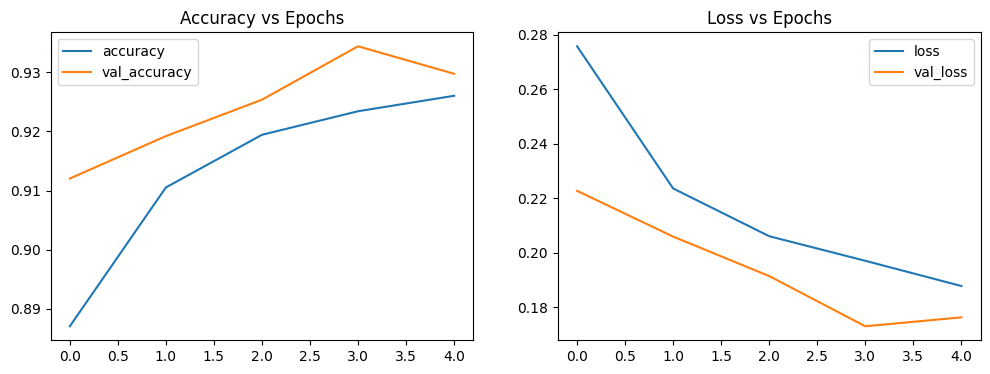

158/158 [==============================] - 623s 4s/step
Classification Report - VGG16
              precision    recall  f1-score   support

           O       0.78      0.99      0.87      1401
           R       0.98      0.65      0.78      1112

    accuracy                           0.84      2513
   macro avg       0.88      0.82      0.83      2513
weighted avg       0.87      0.84      0.83      2513



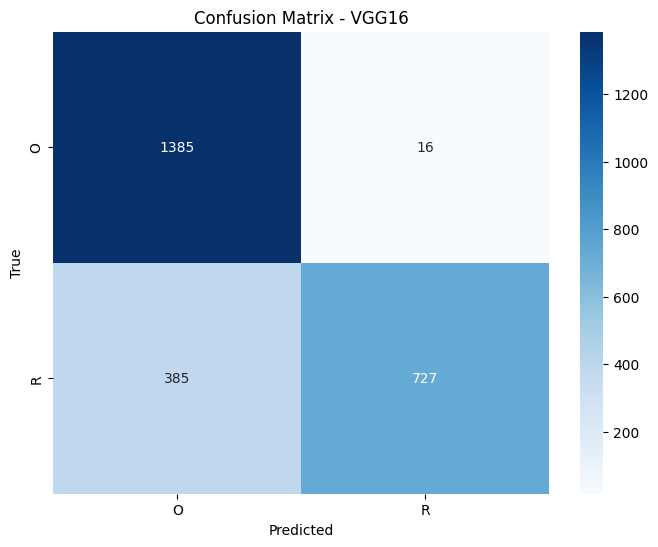

In [75]:
# Train and evaluate VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_accuracy = train_and_evaluate_transfer_learning_model(vgg16_base, 'VGG16', train_generator_vgg16, validation_generator_vgg16, test_generator_vgg16)

- From the above findings it shows that the model is generally performing well , it generalize well to the unseen data. Though is a small evidence of overfitting.
- The overall accuracy is 84% this shows that 84% of the total  images were correctly classified which demonstrate a good performance.
-  According to the confusion matrix the model was able to predict 1385 instances correctly as "Organic" and 16 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 385 instances  were incorrectly predicted as "Recyclable  while 727 samples were correctly predicted as "Recyclable".

### RESNET50

Epoch 1/5
1411/1411 [==============================] - 5776s 4s/step - loss: 0.5392 - accuracy: 0.7367 - val_loss: 0.4773 - val_accuracy: 0.7792
Epoch 2/5
1411/1411 [==============================] - 5863s 4s/step - loss: 0.4883 - accuracy: 0.7711 - val_loss: 0.5129 - val_accuracy: 0.7491
Epoch 3/5
1411/1411 [==============================] - 5880s 4s/step - loss: 0.4714 - accuracy: 0.7810 - val_loss: 0.4398 - val_accuracy: 0.8018
Epoch 4/5
1411/1411 [==============================] - 5861s 4s/step - loss: 0.4596 - accuracy: 0.7860 - val_loss: 0.4274 - val_accuracy: 0.8123
Epoch 5/5
1411/1411 [==============================] - 5923s 4s/step - loss: 0.4495 - accuracy: 0.7948 - val_loss: 0.4152 - val_accuracy: 0.8139


C:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


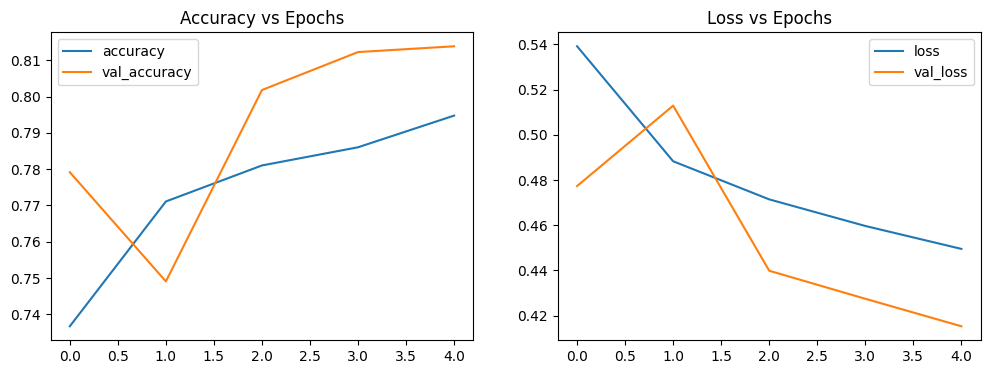

158/158 [==============================] - 333s 2s/step
Classification Report - ResNet50
              precision    recall  f1-score   support

           O       0.78      0.91      0.84      1401
           R       0.86      0.68      0.76      1112

    accuracy                           0.81      2513
   macro avg       0.82      0.80      0.80      2513
weighted avg       0.82      0.81      0.80      2513



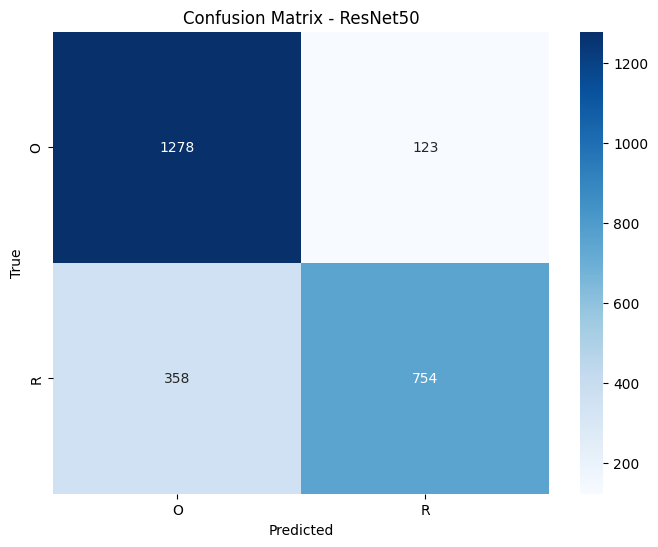

In [76]:
# Train and evaluate ResNet50
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_accuracy = train_and_evaluate_transfer_learning_model(resnet50_base, 'ResNet50', train_generator_vgg16, validation_generator_vgg16, test_generator_vgg16)

- The ResNet50 models indicates a good performance with ann overall accuracy of 81% meaning that the model generalize well to unseen data training and it is able to predict 81% of the images correctly for both classes. There is no evidence of overfitting.
- Base on the confusion matrix, the model was able to predict 1278 organic instances correctly as "Organics" and 123 of organic wastes were incorrectly predicted as "Recyclable". While it was able to predict and classify 754 instances of Recyclable correctly and incorrectly classified 358 instances of Recyclable as Organic.

### EFFICIENTNETB0

Epoch 1/5
1411/1411 [==============================] - 1655s 1s/step - loss: 0.6851 - accuracy: 0.5673 - val_loss: 0.6719 - val_accuracy: 0.5772
Epoch 2/5
1411/1411 [==============================] - 1638s 1s/step - loss: 0.6746 - accuracy: 0.5782 - val_loss: 0.6643 - val_accuracy: 0.5985
Epoch 3/5
1411/1411 [==============================] - 1634s 1s/step - loss: 0.6703 - accuracy: 0.5887 - val_loss: 0.6605 - val_accuracy: 0.5980
Epoch 4/5
1411/1411 [==============================] - 1622s 1s/step - loss: 0.6693 - accuracy: 0.5891 - val_loss: 0.6602 - val_accuracy: 0.5921
Epoch 5/5
1411/1411 [==============================] - 1635s 1s/step - loss: 0.6670 - accuracy: 0.5958 - val_loss: 0.6602 - val_accuracy: 0.6141


C:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


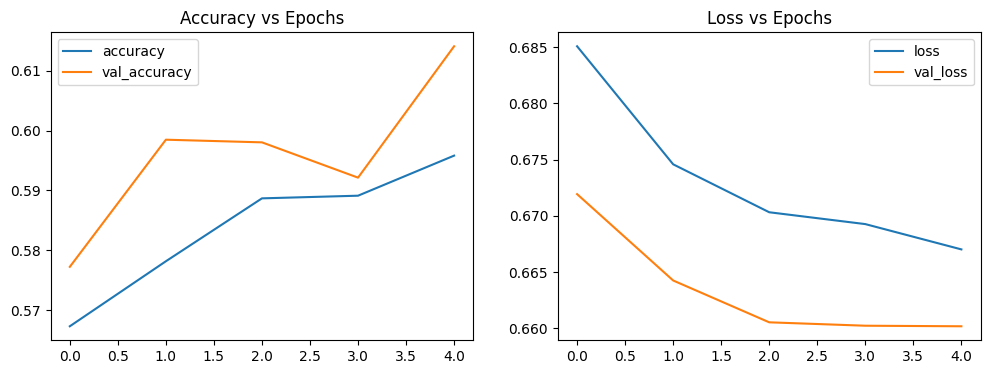

158/158 [==============================] - 93s 582ms/step
Classification Report - EfficientNetB0
              precision    recall  f1-score   support

           O       0.57      0.95      0.71      1401
           R       0.59      0.09      0.15      1112

    accuracy                           0.57      2513
   macro avg       0.58      0.52      0.43      2513
weighted avg       0.58      0.57      0.46      2513



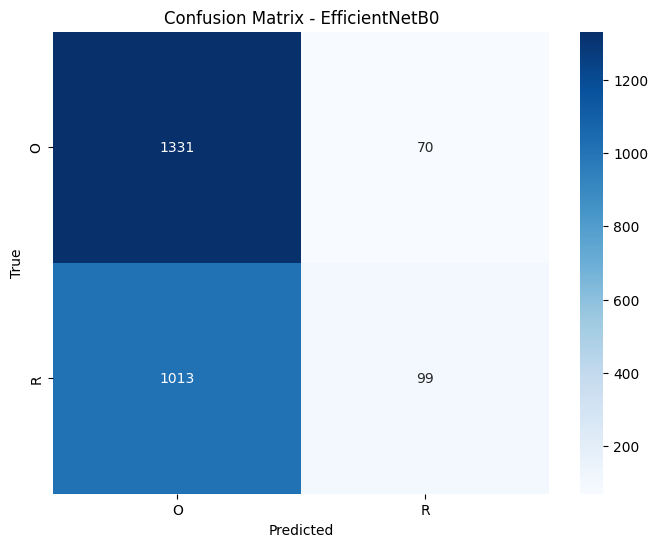

In [77]:
# Train and evaluate EfficientNetB0
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnet_accuracy = train_and_evaluate_transfer_learning_model(efficientnet_base, 'EfficientNetB0', train_generator_vgg16, validation_generator_vgg16, test_generator_vgg16)

- The EfficientB0 model demonstrates a moderate performance, with validation accuracy eventually surpassing training accuracy this suggests that the model generalizes reasonably well. However, the classification report shows an imbalanced performance between the two classes.
-  According to the confusion matrix the model was able to predict 1331 instances correctly as "Organic" and 70 instances were incorrectly predicted as "Recyclable " when they were actually "Organic". Also, 99 instances were correctly predicted as "Recyclable while 1013 samples of "Recyclable" were incorrectly predicted as "Organic". The high misclassification of Recyclables suggests that the model finds it difficult to differentiate between the two classes.
  

### DENSENET121

Epoch 1/5
1411/1411 [==============================] - 4491s 3s/step - loss: 0.1999 - accuracy: 0.9250 - val_loss: 0.1557 - val_accuracy: 0.9424
Epoch 2/5
1411/1411 [==============================] - 4505s 3s/step - loss: 0.1478 - accuracy: 0.9451 - val_loss: 0.1033 - val_accuracy: 0.9627
Epoch 3/5
1411/1411 [==============================] - 4485s 3s/step - loss: 0.1286 - accuracy: 0.9529 - val_loss: 0.1086 - val_accuracy: 0.9599
Epoch 4/5
1411/1411 [==============================] - 4497s 3s/step - loss: 0.1192 - accuracy: 0.9563 - val_loss: 0.0829 - val_accuracy: 0.9696
Epoch 5/5
1411/1411 [==============================] - 4475s 3s/step - loss: 0.1117 - accuracy: 0.9586 - val_loss: 0.0794 - val_accuracy: 0.9704


C:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


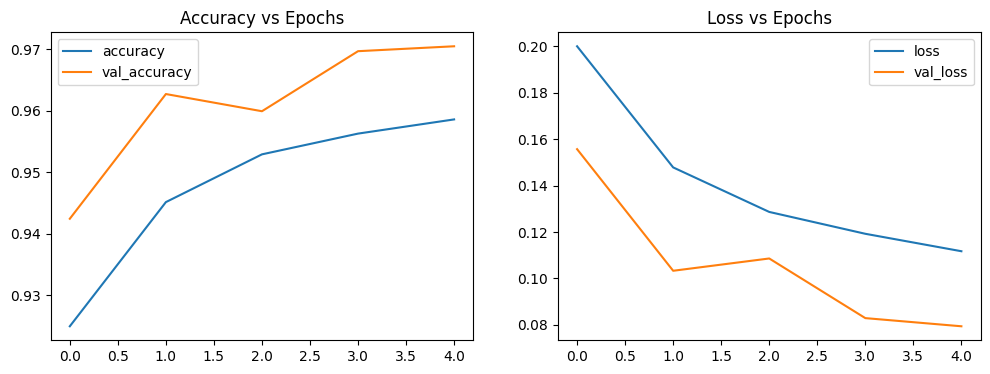

158/158 [==============================] - 250s 2s/step
Classification Report - DenseNet121
              precision    recall  f1-score   support

           O       0.87      0.99      0.93      1401
           R       0.99      0.82      0.89      1112

    accuracy                           0.91      2513
   macro avg       0.93      0.90      0.91      2513
weighted avg       0.92      0.91      0.91      2513



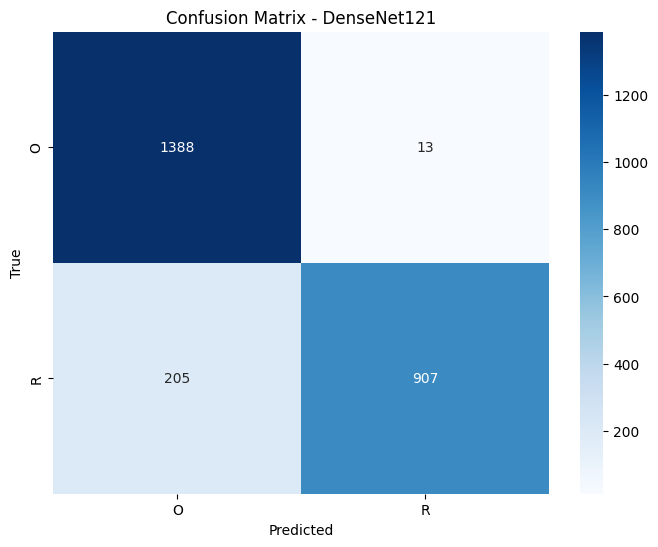

In [78]:
# Train and evaluate DenseNet121
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet_accuracy = train_and_evaluate_transfer_learning_model(densenet_base, 'DenseNet121', train_generator_vgg16, validation_generator_vgg16, test_generator_vgg16)

- The DenseNet121 model achieved an overall highest accuracy of 91% with high precision and recall for both classes. This suggests that the model generalizes very well.
- The model predicted 1388 instances of Organic correctly and 13 instances were incorrectly classified as Recyclable. While it correctly predicted 907 instances as Recyclable 205 instances  were incorrectly predicted as Organic

### INCEPTIONV3

Epoch 1/5
1411/1411 [==============================] - 3442s 2s/step - loss: 0.2475 - accuracy: 0.9040 - val_loss: 0.1537 - val_accuracy: 0.9422
Epoch 2/5
1411/1411 [==============================] - 3471s 2s/step - loss: 0.1877 - accuracy: 0.9261 - val_loss: 0.1454 - val_accuracy: 0.9435
Epoch 3/5
1411/1411 [==============================] - 3544s 3s/step - loss: 0.1655 - accuracy: 0.9354 - val_loss: 0.1248 - val_accuracy: 0.9529
Epoch 4/5
1411/1411 [==============================] - 3519s 2s/step - loss: 0.1588 - accuracy: 0.9389 - val_loss: 0.1134 - val_accuracy: 0.9566
Epoch 5/5
1411/1411 [==============================] - 3505s 2s/step - loss: 0.1466 - accuracy: 0.9428 - val_loss: 0.1059 - val_accuracy: 0.9599


C:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


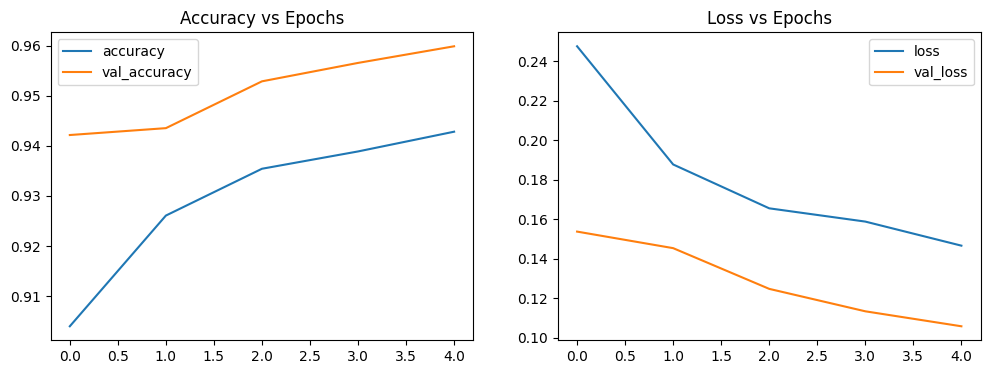

158/158 [==============================] - 201s 1s/step
Classification Report - InceptionV3
              precision    recall  f1-score   support

           O       0.87      0.98      0.92      1401
           R       0.97      0.81      0.88      1112

    accuracy                           0.90      2513
   macro avg       0.92      0.89      0.90      2513
weighted avg       0.91      0.90      0.90      2513



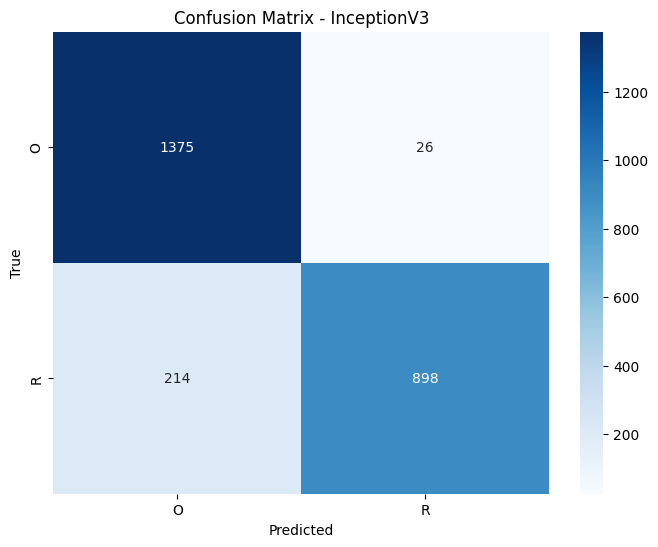

In [79]:
# Train and evaluate InceptionV3
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_accuracy = train_and_evaluate_transfer_learning_model(inception_base, 'InceptionV3', train_generator_vgg16, validation_generator_vgg16, test_generator_vgg16)

- The model's overall accuracy is 90% and the above findings shows that the model performs well with increasing accuracy and decreasing loss.
- The model predicted 1375 correctly as Organic and 26 instances of organic were incorrectly predicted as Recyclable. While 898 Recyclables were correctly predicted as Recyclable and 214 Recyclables predicted incorrectly as organic.

In [80]:
# Add transfer learning accuracies to the dictionary
model_accuracies['CNN'] = cnn_accuracy
model_accuracies['VGG16'] = vgg16_accuracy
model_accuracies['ResNet50'] = resnet50_accuracy
model_accuracies['EfficientNetB0'] = efficientnet_accuracy
model_accuracies['DenseNet121'] = densenet_accuracy
model_accuracies['InceptionV3'] = inception_accuracy

### HYPERPARAMETER TUNING

### CNN

In [81]:
# Hyperparameter tuning for CNN model using Keras Tuner
def build_cnn(hp):
    model = Sequential([
        # First Convolutional Layer
        Conv2D(filters=hp.Choice('conv_filters_1', [32, 64, 128]),
               kernel_size=hp.Choice('conv_kernel_size_1', [3, 5]),
               input_shape=(150, 150, 3), activation='relu'),
        MaxPooling2D(pool_size=2),

        # Second Convolutional Layer
        Conv2D(filters=hp.Choice('conv_filters_2', [64, 128, 256]),
               kernel_size=hp.Choice('conv_kernel_size_2', [3, 5]),
               activation='relu'),
        MaxPooling2D(pool_size=2),

        # Third Convolutional Layer
        Conv2D(filters=hp.Choice('conv_filters_3', [128, 256, 512]),
               kernel_size=hp.Choice('conv_kernel_size_3', [3, 5]),
               activation='relu'),
        MaxPooling2D(pool_size=2),

        # Fourth Convolutional Layer
        Conv2D(filters=hp.Choice('conv_filters_4', [256, 512]),
               kernel_size=hp.Choice('conv_kernel_size_4', [3, 5]),
               activation='relu'),
        MaxPooling2D(pool_size=2),

        # Flatten and Dense Layers
        Flatten(),
        Dense(units=hp.Choice('dense_units', [64, 128, 256]), activation='relu'),
        Dropout(hp.Choice('dropout_rate', [0.3, 0.5, 0.7])),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0001])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [82]:
# Hyperparameter tuning with Keras Tuner
tuner = RandomSearch(
    build_cnn,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='cnn_tuner',
    project_name='cnn_tuning'
)

Reloading Tuner from cnn_tuner\cnn_tuning\tuner0.json


In [83]:
tuner.search(train_generator, epochs=10, validation_data=validation_generator, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

In [84]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [85]:
# Build the model with the optimal hyperparameters
cnn_model_optimized = tuner.hypermodel.build(best_hps)

In [86]:
# Train the CNN model with the best hyperparameters
history_optimized = cnn_model_optimized.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/20
565/565 [==============================] - 1761s 3s/step - loss: 0.6913 - accuracy: 0.5537 - val_loss: 0.6855 - val_accuracy: 0.5657
Epoch 2/20
565/565 [==============================] - 1754s 3s/step - loss: 0.6876 - accuracy: 0.5547 - val_loss: 0.6855 - val_accuracy: 0.5657
Epoch 3/20
565/565 [==============================] - 1769s 3s/step - loss: 0.6873 - accuracy: 0.5547 - val_loss: 0.6847 - val_accuracy: 0.5657
Epoch 4/20
565/565 [==============================] - 1762s 3s/step - loss: 0.6874 - accuracy: 0.5547 - val_loss: 0.6848 - val_accuracy: 0.5657
Epoch 5/20
565/565 [==============================] - 1762s 3s/step - loss: 0.6873 - accuracy: 0.5547 - val_loss: 0.6846 - val_accuracy: 0.5657
Epoch 6/20
565/565 [==============================] - 1766s 3s/step - loss: 0.6872 - accuracy: 0.5547 - val_loss: 0.6847 - val_accuracy: 0.5657
Epoch 7/20
565/565 [==============================] - 1747s 3s/step - loss: 0.6872 - accuracy: 0.5547 - val_loss: 0.6848 - val_accuracy:

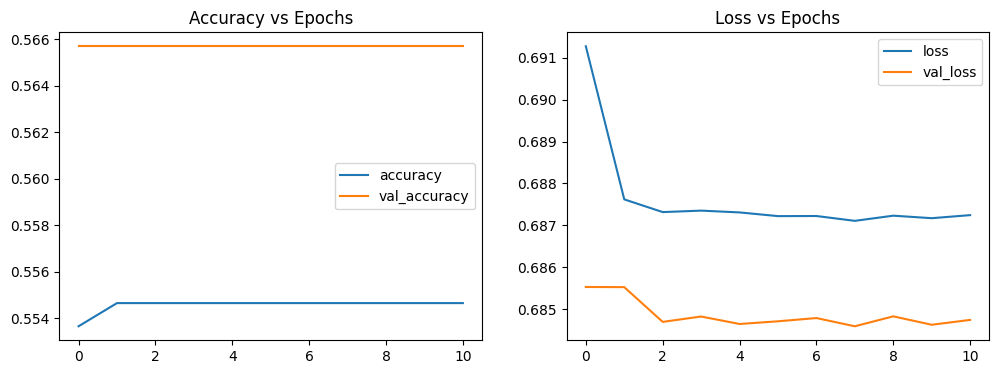

In [87]:
plot_training_history(history_optimized)

C:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 35s 444ms/step
              precision    recall  f1-score   support

           O       0.56      1.00      0.72      1401
           R       1.00      0.00      0.00      1112

    accuracy                           0.56      2513
   macro avg       0.78      0.50      0.36      2513
weighted avg       0.75      0.56      0.40      2513



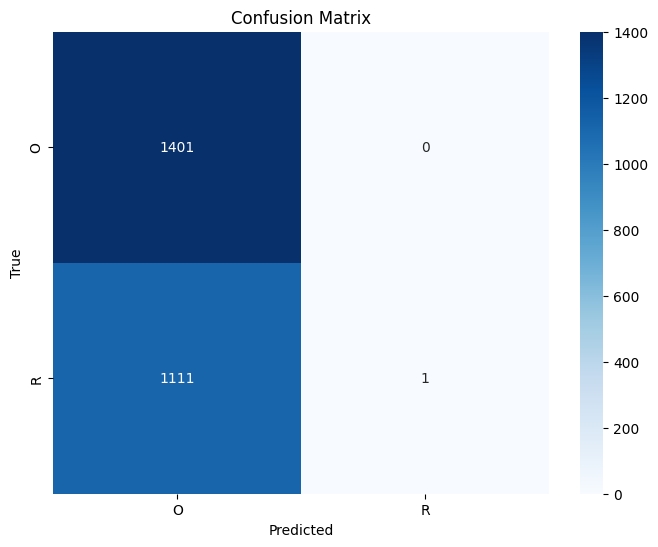

In [88]:
# Save the optimized model
cnn_model_optimized.save('cnn_model_optimized.h5')
cnn_optimized_accuracy = evaluate_cnn_model(cnn_model_optimized, test_generator, test_steps_per_epoch)
model_accuracies['CNN Optimized'] = cnn_optimized_accuracy

- The model's performance is a significant imbalance as it perfectly classified all instances of Organic and failed to classify any instances of Recyclable. The accuracy of 56% suggests that the model did not perform well.

In [89]:
model_accuracies['CNN Optimized'] = cnn_optimized_accuracy

# Hyperparameter tuning for traditional ML models with PCA

### RANDOM FOREST

In [90]:
# Hyperparameter tuning for Random Forest with PCA
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_train_pca, y_train)
rf_best = rf_grid.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [91]:
rf_predictions = rf_best.predict(X_val_pca)
print("Random Forest with PCA - Tuned")
print(classification_report(y_val, rf_predictions, target_names=['Organic', 'Recyclable']))

Random Forest with PCA - Tuned
              precision    recall  f1-score   support

     Organic       0.70      0.83      0.76      2553
  Recyclable       0.71      0.53      0.61      1960

    accuracy                           0.70      4513
   macro avg       0.70      0.68      0.68      4513
weighted avg       0.70      0.70      0.69      4513



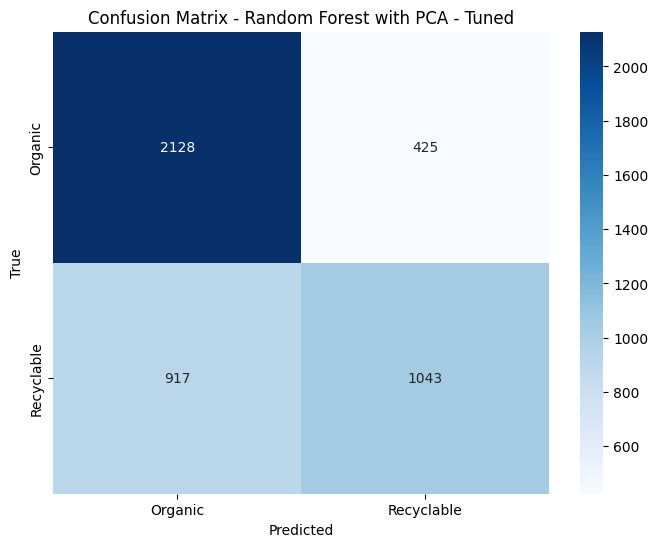

In [92]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_val, rf_predictions)
plot_confusion_matrix(cm_rf, 'Confusion Matrix - Random Forest with PCA - Tuned')

- The findings shows that the model correctly classified 2128 organic wastes and 1043 recyclable wastes respectively but misclassified 425 of organic wastes as  Recyclable  and 917 recyclables wastes as organic.

In [93]:
# Store accuracy
model_accuracies['Random Forest with PCA - Tuned'] = accuracy_score(y_val, rf_predictions)

### ADABOOST

In [94]:
# Hyperparameter tuning for AdaBoost with PCA
adaboost_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

In [95]:
adaboost_grid = GridSearchCV(adaboost_model, adaboost_params, cv=3, n_jobs=-1, verbose=1)
adaboost_grid.fit(X_train_pca, y_train)
adaboost_best = adaboost_grid.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [96]:
adaboost_predictions = adaboost_best.predict(X_val_pca)
print("AdaBoost with PCA - Tuned")
print(classification_report(y_val, adaboost_predictions, target_names=['Organic', 'Recyclable']))

AdaBoost with PCA - Tuned
              precision    recall  f1-score   support

     Organic       0.68      0.82      0.74      2553
  Recyclable       0.68      0.50      0.58      1960

    accuracy                           0.68      4513
   macro avg       0.68      0.66      0.66      4513
weighted avg       0.68      0.68      0.67      4513



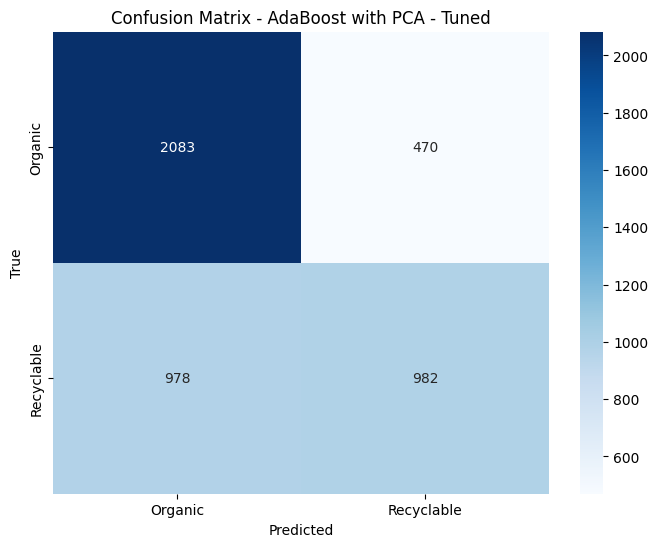

In [97]:
# Confusion Matrix for AdaBoost
cm_adaboost = confusion_matrix(y_val, adaboost_predictions)
plot_confusion_matrix(cm_adaboost, 'Confusion Matrix - AdaBoost with PCA - Tuned')

- The above findings reveal that the model had difficulty in identifying Recyclable wastes and correctly identifies most organic wastes.

In [98]:
# Store accuracy
model_accuracies['AdaBoost with PCA - Tuned'] = accuracy_score(y_val, adaboost_predictions)

### XGBOOST

In [99]:
# Hyperparameter tuning for XGBoost with PCA
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_pca, y_train)
xgb_best = xgb_grid.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\749458\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [09:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [100]:
xgb_predictions = xgb_best.predict(X_val_pca)
print("XGBoost with PCA - Tuned")
print(classification_report(y_val, xgb_predictions, target_names=['Organic', 'Recyclable']))

XGBoost with PCA - Tuned
              precision    recall  f1-score   support

     Organic       0.70      0.80      0.75      2553
  Recyclable       0.68      0.56      0.61      1960

    accuracy                           0.69      4513
   macro avg       0.69      0.68      0.68      4513
weighted avg       0.69      0.69      0.69      4513



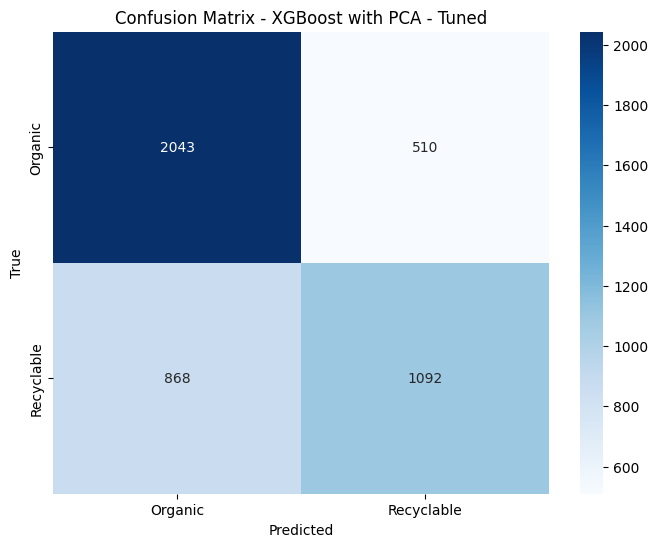

In [101]:
# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_val, xgb_predictions)
plot_confusion_matrix(cm_xgb, 'Confusion Matrix - XGBoost with PCA - Tuned')

- The XGBoost model with PCA tuning indicates good performance in classifiying Organic wastes but didn't do well in classifying recyclable wastes. 

In [102]:
# Store accuracy
model_accuracies['XGBoost with PCA - Tuned'] = accuracy_score(y_val, xgb_predictions)

### NAIVE BAYES

In [103]:
# Hyperparameter tuning for Naive Bayes with PCA
# Naive Bayes does not have hyperparameters to tune like other models, but we can evaluate its performance directly.

### SVM

In [104]:
# Hyperparameter tuning for SVM with PCA
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

In [105]:
svm_grid = GridSearchCV(svm_model, svm_params, cv=3, n_jobs=-1, verbose=1)
svm_grid.fit(X_train_pca, y_train)
svm_best = svm_grid.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [106]:
svm_predictions = svm_best.predict(X_val_pca)
print("SVM with PCA - Tuned")
print(classification_report(y_val, svm_predictions, target_names=['Organic', 'Recyclable']))

SVM with PCA - Tuned
              precision    recall  f1-score   support

     Organic       0.71      0.80      0.75      2553
  Recyclable       0.69      0.57      0.62      1960

    accuracy                           0.70      4513
   macro avg       0.70      0.69      0.69      4513
weighted avg       0.70      0.70      0.70      4513



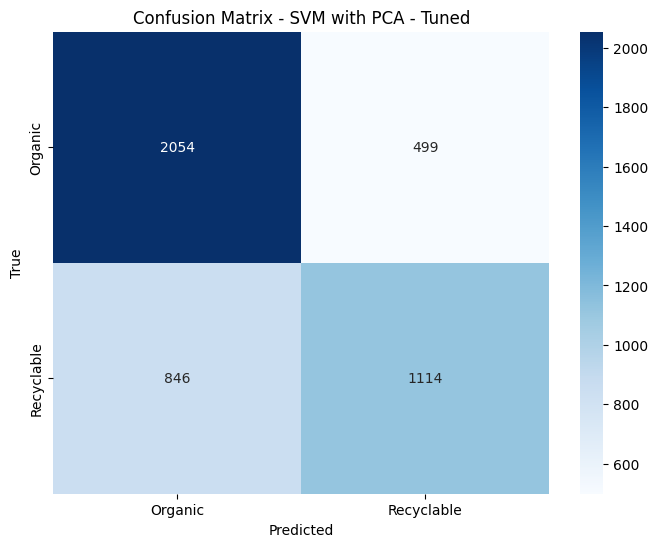

In [107]:
# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_val, svm_predictions)
plot_confusion_matrix(cm_svm, 'Confusion Matrix - SVM with PCA - Tuned')

# Store accuracy
model_accuracies['SVM with PCA - Tuned'] = accuracy_score(y_val, svm_predictions)

- The model's overall accuracy of 70% suggests that the model moderately performs well, but still struggle to correctly predict Recyclable wastes.

### LOGISTICS REGRESSION

In [108]:
# Hyperparameter tuning for Logistic Regression with PCA
lr_params = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

In [109]:
lr_grid = GridSearchCV(lr_model, lr_params, cv=3, n_jobs=-1, verbose=1)
lr_grid.fit(X_train_pca, y_train)
lr_best = lr_grid.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [110]:
lr_predictions = lr_best.predict(X_val_pca)
print("Logistic Regression with PCA - Tuned")
print(classification_report(y_val, lr_predictions, target_names=['Organic', 'Recyclable']))

Logistic Regression with PCA - Tuned
              precision    recall  f1-score   support

     Organic       0.68      0.76      0.72      2553
  Recyclable       0.63      0.54      0.58      1960

    accuracy                           0.66      4513
   macro avg       0.66      0.65      0.65      4513
weighted avg       0.66      0.66      0.66      4513



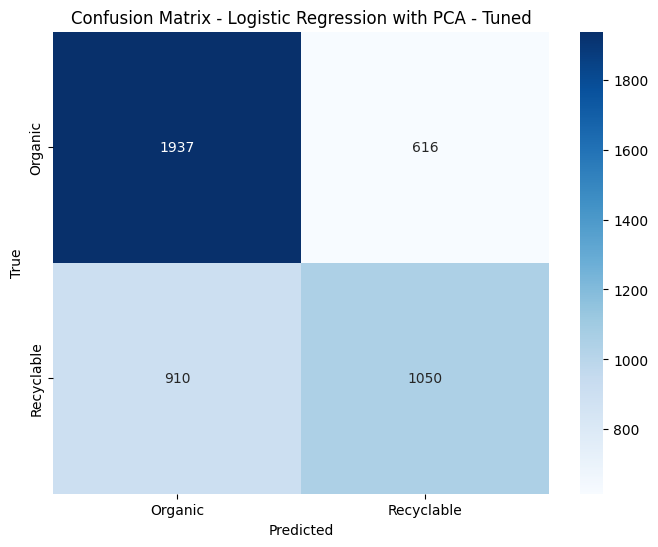

In [111]:
# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_val, lr_predictions)
plot_confusion_matrix(cm_lr, 'Confusion Matrix - Logistic Regression with PCA - Tuned')

# Store accuracy
model_accuracies['Logistic Regression with PCA - Tuned'] = accuracy_score(y_val, lr_predictions)

# Hyperparameter tuning for traditional ML models without PCA

### RANDOM FOREST 

In [112]:
# Hyperparameter tuning for Random Forest without PCA
rf_grid_no_pca = GridSearchCV(rf_model_no_pca, rf_params, cv=3, n_jobs=-1, verbose=1)
rf_grid_no_pca.fit(X_train_scaled, y_train)
rf_best_no_pca = rf_grid_no_pca.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [113]:
rf_predictions_no_pca = rf_best_no_pca.predict(X_val_scaled)
print("Random Forest - Tuned")
print(classification_report(y_val, rf_predictions_no_pca, target_names=['Organic', 'Recyclable']))

Random Forest - Tuned
              precision    recall  f1-score   support

     Organic       0.71      0.84      0.77      2553
  Recyclable       0.72      0.55      0.62      1960

    accuracy                           0.71      4513
   macro avg       0.71      0.69      0.69      4513
weighted avg       0.71      0.71      0.70      4513



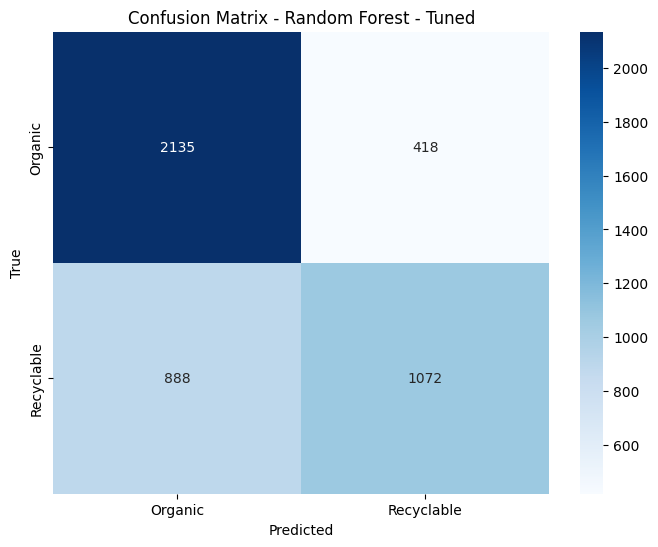

In [114]:
# Confusion Matrix for Random Forest
cm_rf_no_pca = confusion_matrix(y_val, rf_predictions_no_pca)
plot_confusion_matrix(cm_rf_no_pca, 'Confusion Matrix - Random Forest - Tuned')

In [115]:
# Store accuracy
model_accuracies['Random Forest - Tuned'] = accuracy_score(y_val, rf_predictions_no_pca)

### ADABOOST 

In [116]:
# Hyperparameter tuning for AdaBoost without PCA
adaboost_grid_no_pca = GridSearchCV(adaboost_model_no_pca, adaboost_params, cv=3, n_jobs=-1, verbose=1)
adaboost_grid_no_pca.fit(X_train_scaled, y_train)
adaboost_best_no_pca = adaboost_grid_no_pca.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [117]:
adaboost_predictions_no_pca = adaboost_best_no_pca.predict(X_val_scaled)
print("AdaBoost - Tuned")
print(classification_report(y_val, adaboost_predictions_no_pca, target_names=['Organic', 'Recyclable']))

AdaBoost - Tuned
              precision    recall  f1-score   support

     Organic       0.69      0.79      0.73      2553
  Recyclable       0.65      0.53      0.59      1960

    accuracy                           0.67      4513
   macro avg       0.67      0.66      0.66      4513
weighted avg       0.67      0.67      0.67      4513



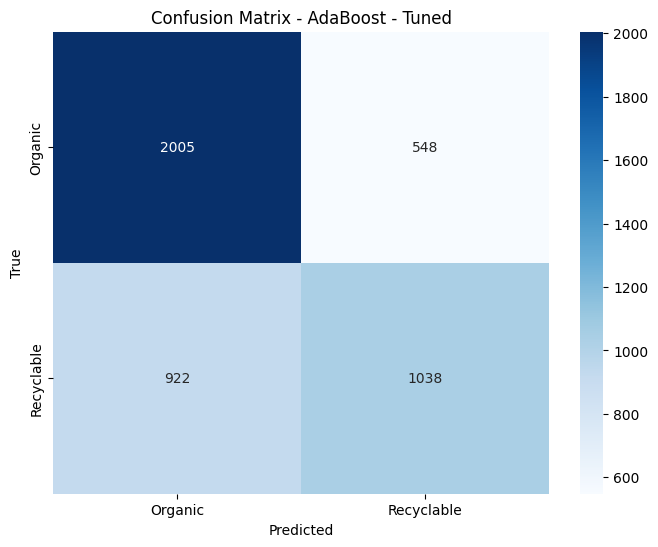

In [118]:
# Confusion Matrix for AdaBoost
cm_adaboost_no_pca = confusion_matrix(y_val, adaboost_predictions_no_pca)
plot_confusion_matrix(cm_adaboost_no_pca, 'Confusion Matrix - AdaBoost - Tuned')

In [119]:
# Store accuracy
model_accuracies['AdaBoost - Tuned'] = accuracy_score(y_val, adaboost_predictions_no_pca)

### XGBOOST 

In [120]:
# Hyperparameter tuning for XGBoost without PCA
xgb_grid_no_pca = GridSearchCV(xgb_model_no_pca, xgb_params, cv=3, n_jobs=-1, verbose=1)
xgb_grid_no_pca.fit(X_train_scaled, y_train)
xgb_best_no_pca = xgb_grid_no_pca.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\749458\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [09:40:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [121]:
xgb_predictions_no_pca = xgb_best_no_pca.predict(X_val_scaled)
print("XGBoost - Tuned")
print(classification_report(y_val, xgb_predictions_no_pca, target_names=['Organic', 'Recyclable']))

XGBoost - Tuned
              precision    recall  f1-score   support

     Organic       0.73      0.82      0.77      2553
  Recyclable       0.72      0.60      0.65      1960

    accuracy                           0.72      4513
   macro avg       0.72      0.71      0.71      4513
weighted avg       0.72      0.72      0.72      4513



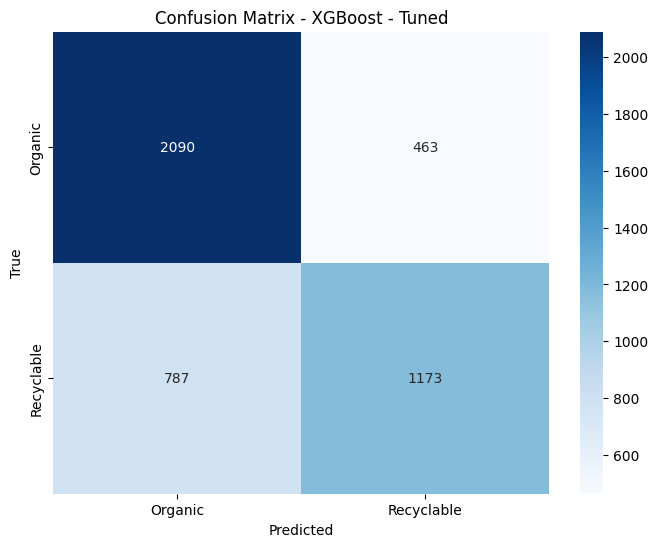

In [122]:
# Confusion Matrix for XGBoost
cm_xgb_no_pca = confusion_matrix(y_val, xgb_predictions_no_pca)
plot_confusion_matrix(cm_xgb_no_pca, 'Confusion Matrix - XGBoost - Tuned')

In [123]:
# Store accuracy
model_accuracies['XGBoost - Tuned'] = accuracy_score(y_val, xgb_predictions_no_pca)

### NAIVE NAYES

In [124]:
# Hyperparameter tuning for Naive Bayes without PCA
# Naive Bayes does not have hyperparameters to tune like other models, but we can evaluate its performance directly.

### SVM 

In [125]:
# Hyperparameter tuning for SVM without PCA
svm_grid_no_pca = GridSearchCV(svm_model_no_pca, svm_params, cv=3, n_jobs=-1, verbose=1)
svm_grid_no_pca.fit(X_train_scaled, y_train)
svm_best_no_pca = svm_grid_no_pca.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [126]:
svm_predictions_no_pca = svm_best_no_pca.predict(X_val_scaled)
print("SVM - Tuned")
print(classification_report(y_val, svm_predictions_no_pca, target_names=['Organic', 'Recyclable']))

SVM - Tuned
              precision    recall  f1-score   support

     Organic       0.70      0.83      0.76      2553
  Recyclable       0.71      0.54      0.61      1960

    accuracy                           0.70      4513
   macro avg       0.71      0.68      0.69      4513
weighted avg       0.70      0.70      0.70      4513



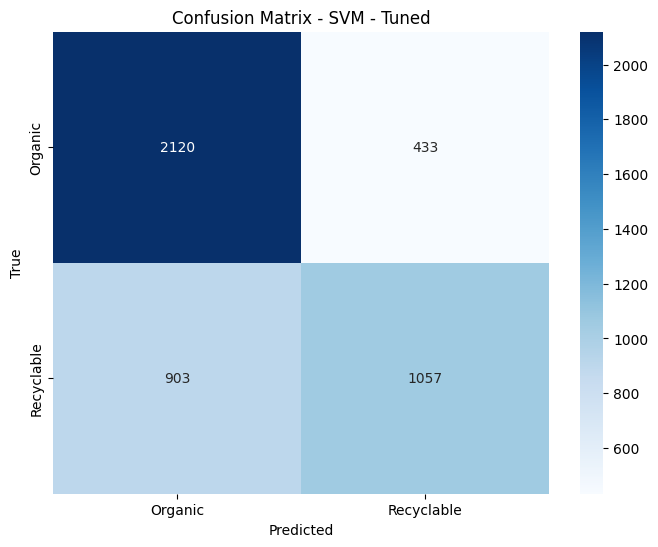

In [127]:
# Confusion Matrix for SVM
cm_svm_no_pca = confusion_matrix(y_val, svm_predictions_no_pca)
plot_confusion_matrix(cm_svm_no_pca, 'Confusion Matrix - SVM - Tuned')

# Store accuracy
model_accuracies['SVM - Tuned'] = accuracy_score(y_val, svm_predictions_no_pca)

### LOGISTICS REGRESSION 

In [128]:
# Hyperparameter tuning for Logistic Regression without PCA
lr_grid_no_pca = GridSearchCV(lr_model_no_pca, lr_params, cv=3, n_jobs=-1, verbose=1)
lr_grid_no_pca.fit(X_train_scaled, y_train)
lr_best_no_pca = lr_grid_no_pca.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [129]:
lr_predictions_no_pca = lr_best_no_pca.predict(X_val_scaled)
print("Logistic Regression - Tuned")
print(classification_report(y_val, lr_predictions_no_pca, target_names=['Organic', 'Recyclable']))

Logistic Regression - Tuned
              precision    recall  f1-score   support

     Organic       0.68      0.74      0.71      2553
  Recyclable       0.62      0.54      0.58      1960

    accuracy                           0.66      4513
   macro avg       0.65      0.64      0.65      4513
weighted avg       0.65      0.66      0.65      4513



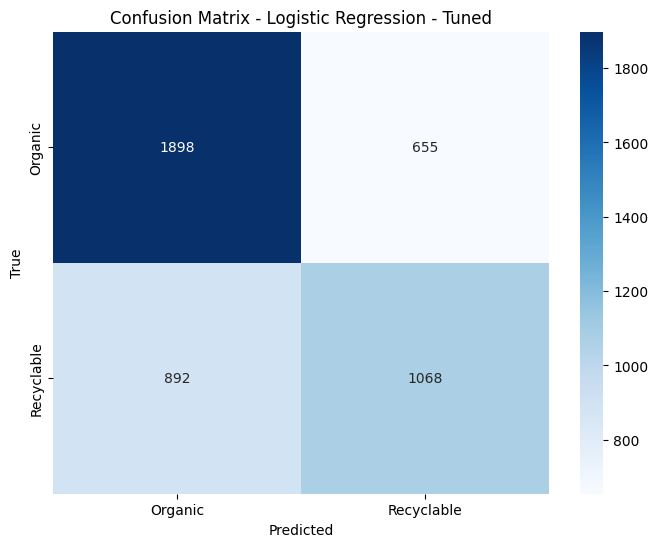

In [130]:
# Confusion Matrix for Logistic Regression
cm_lr_no_pca = confusion_matrix(y_val, lr_predictions_no_pca)
plot_confusion_matrix(cm_lr_no_pca, 'Confusion Matrix - Logistic Regression - Tuned')

# Store accuracy
model_accuracies['Logistic Regression - Tuned'] = accuracy_score(y_val, lr_predictions_no_pca)


- The accuracy of 66% indicates a moderate performance. The number of false positives and false negatives is significantly high and this suggests that the model needs further improvement. 

### STACKING MODEL

#### Stacking with PCA

In [131]:
# Train Stacking with PCA
base_models_pca = [
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True)),
    ('lr', LogisticRegression(max_iter=500))
]

In [132]:
stacking_model_pca = StackingClassifier(estimators=base_models_pca, final_estimator=LogisticRegression(max_iter=500))
stacking_model_pca.fit(X_train_pca, y_train)
stacking_predictions_pca = stacking_model_pca.predict(X_val_pca)

In [133]:
print("Stacking Model with PCA")
print(classification_report(y_val, stacking_predictions_pca, target_names=['Organic', 'Recyclable']))

Stacking Model with PCA
              precision    recall  f1-score   support

     Organic       0.71      0.81      0.76      2553
  Recyclable       0.70      0.56      0.62      1960

    accuracy                           0.70      4513
   macro avg       0.70      0.69      0.69      4513
weighted avg       0.70      0.70      0.70      4513



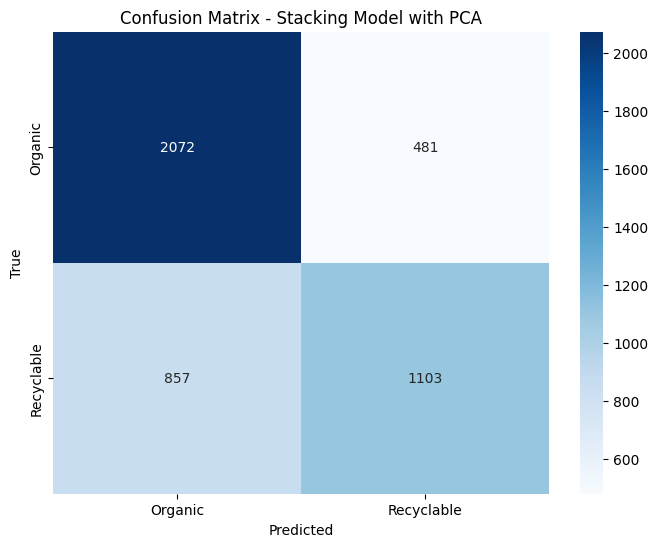

In [134]:
# Confusion Matrix for Stacking Model
cm_stacking_pca = confusion_matrix(y_val, stacking_predictions_pca)
plot_confusion_matrix(cm_stacking_pca, 'Confusion Matrix - Stacking Model with PCA')

# Store accuracy
model_accuracies['Stacking Model with PCA'] = accuracy_score(y_val, stacking_predictions_pca)

- The stacking model with PCA has a decent performance with an overall accuracy of 70%. Findings from the confusion matrix show that 2072 organic wastes were correctly predicted as organic and 481 were incorrectly predicted as recyclable. 1103 of recyclable wastes were correctly predicted while 857 were incorrectly predicted as organic.

### Stacking without PCA

In [135]:
# Train Stacking without PCA
base_models_no_pca = [
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True)),
    ('lr', LogisticRegression(max_iter=500))
]

In [136]:
stacking_model_no_pca = StackingClassifier(estimators=base_models_no_pca, final_estimator=LogisticRegression(max_iter=500))
stacking_model_no_pca.fit(X_train_scaled, y_train)
stacking_predictions_no_pca = stacking_model_no_pca.predict(X_val_scaled)

In [137]:
print("Stacking Model")
print(classification_report(y_val, stacking_predictions_no_pca, target_names=['Organic', 'Recyclable']))

Stacking Model
              precision    recall  f1-score   support

     Organic       0.72      0.83      0.77      2553
  Recyclable       0.72      0.58      0.64      1960

    accuracy                           0.72      4513
   macro avg       0.72      0.70      0.71      4513
weighted avg       0.72      0.72      0.72      4513



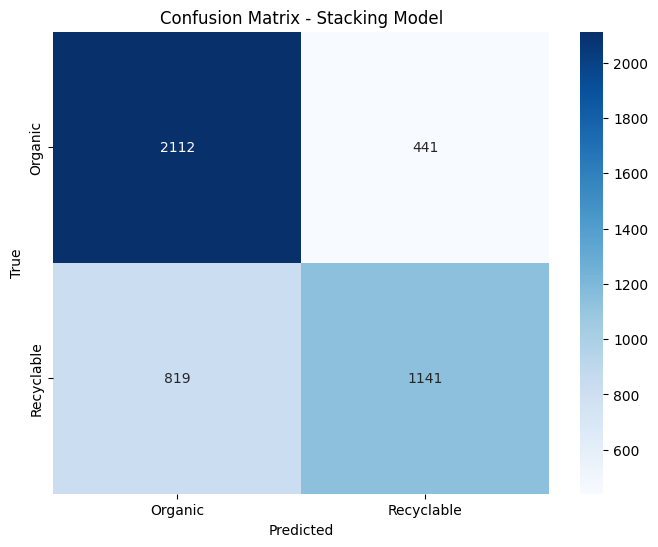

In [138]:
# Confusion Matrix for Stacking Model
cm_stacking_no_pca = confusion_matrix(y_val, stacking_predictions_no_pca)
plot_confusion_matrix(cm_stacking_no_pca, 'Confusion Matrix - Stacking Model')

# Store accuracy
model_accuracies['Stacking Model'] = accuracy_score(y_val, stacking_predictions_no_pca)

- The stacking model without PCA with an overall accuracy of 72% suggests a good performance but the model needs further improvement, particularly in identifying recyclable wastes.
- Findings from the confusion matrix show that 2112 organic wastes were correctly predicted as organic and 441 were incorrectly predicted as recyclable. 1141  recyclable wastes were correctly predicted while 819 were incorrectly predicted as organic.

### HYPERPARAMETER TUNNING STACKING CLASSIFIER

In [139]:
# Hyperparameter tuning for Stacking with PCA
stacking_params = {
    'final_estimator__C': [0.1, 1, 10]
}

In [140]:
stacking_grid_pca = GridSearchCV(stacking_model_pca, stacking_params, cv=3, n_jobs=-1, verbose=1)
stacking_grid_pca.fit(X_train_pca, y_train)
stacking_best_pca = stacking_grid_pca.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [141]:
stacking_predictions_pca = stacking_best_pca.predict(X_val_pca)
print("Stacking Model with PCA - Tuned")
print(classification_report(y_val, stacking_predictions_pca, target_names=['Organic', 'Recyclable']))

Stacking Model with PCA - Tuned
              precision    recall  f1-score   support

     Organic       0.71      0.82      0.76      2553
  Recyclable       0.70      0.56      0.63      1960

    accuracy                           0.71      4513
   macro avg       0.71      0.69      0.69      4513
weighted avg       0.71      0.71      0.70      4513



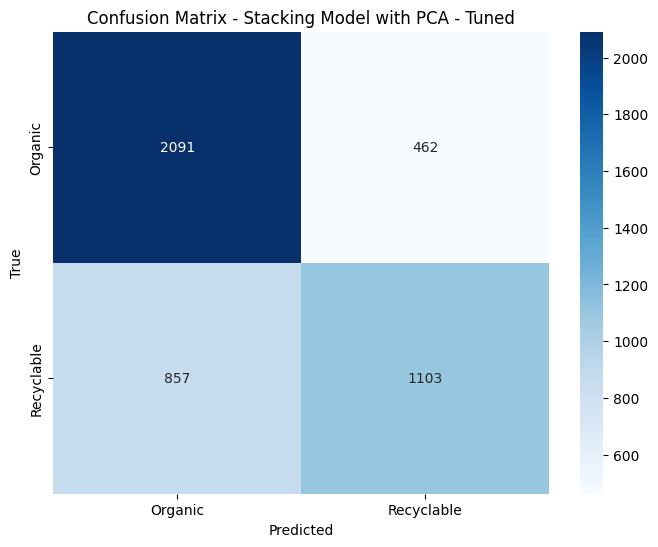

In [142]:
# Confusion Matrix for Stacking Model
cm_stacking_pca = confusion_matrix(y_val, stacking_predictions_pca)
plot_confusion_matrix(cm_stacking_pca, 'Confusion Matrix - Stacking Model with PCA - Tuned')

# Store accuracy
model_accuracies['Stacking Model with PCA - Tuned'] = accuracy_score(y_val, stacking_predictions_pca)

- The stacking model tuned with PCA with an overall accuracy of 71% suggests a good performance but the model needs further improvement, particularly in identifying recyclable wastes.
- Findings from the confusion matrix show that 2091 organic wastes were correctly predicted as organic and 462 were incorrectly predicted as recyclable. 1103  recyclable wastes were correctly predicted while 857 were incorrectly predicted as organic.

In [143]:
# Hyperparameter tuning for Stacking without PCA
stacking_grid_no_pca = GridSearchCV(stacking_model_no_pca, stacking_params, cv=3, n_jobs=-1, verbose=1)
stacking_grid_no_pca.fit(X_train_scaled, y_train)
stacking_best_no_pca = stacking_grid_no_pca.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [144]:
stacking_predictions_no_pca = stacking_best_no_pca.predict(X_val_scaled)
print("Stacking Model - Tuned")
print(classification_report(y_val, stacking_predictions_no_pca, target_names=['Organic', 'Recyclable']))

Stacking Model - Tuned
              precision    recall  f1-score   support

     Organic       0.72      0.82      0.77      2553
  Recyclable       0.71      0.58      0.64      1960

    accuracy                           0.72      4513
   macro avg       0.71      0.70      0.70      4513
weighted avg       0.71      0.72      0.71      4513



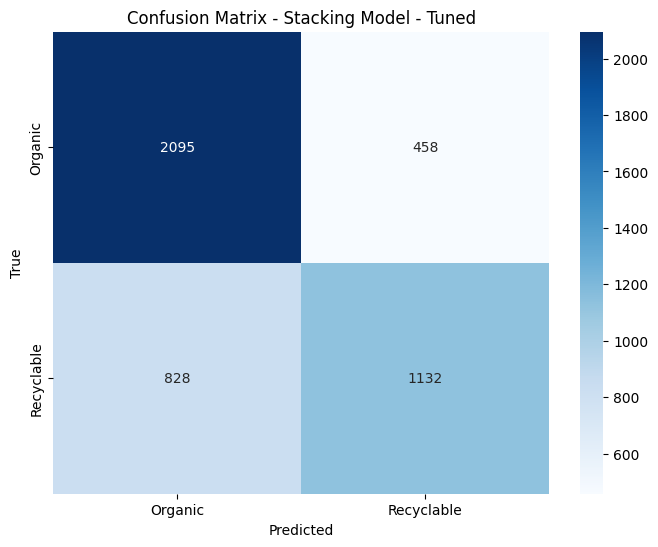

In [145]:
# Plot Confusion Matrix for Stacking Model without PCA
cm_stacking_no_pca = confusion_matrix(y_val, stacking_predictions_no_pca)
plot_confusion_matrix(cm_stacking_no_pca, 'Confusion Matrix - Stacking Model - Tuned')

# Store accuracy of the stacking model without PCA
model_accuracies['Stacking Model - Tuned'] = accuracy_score(y_val, stacking_predictions_no_pca)

- The stacking model tuned without PCA with an overall accuracy of 72% suggests a good performance but the model needs further improvement, particularly in identifying recyclable wastes.
- Findings from the confusion matrix show that 2095 organic wastes were correctly predicted as organic and 458 were incorrectly predicted as recyclable. 1132 recyclable wastes were correctly predicted while 819 were incorrectly predicted as organic.

### COMPARISON OF ACCURACY

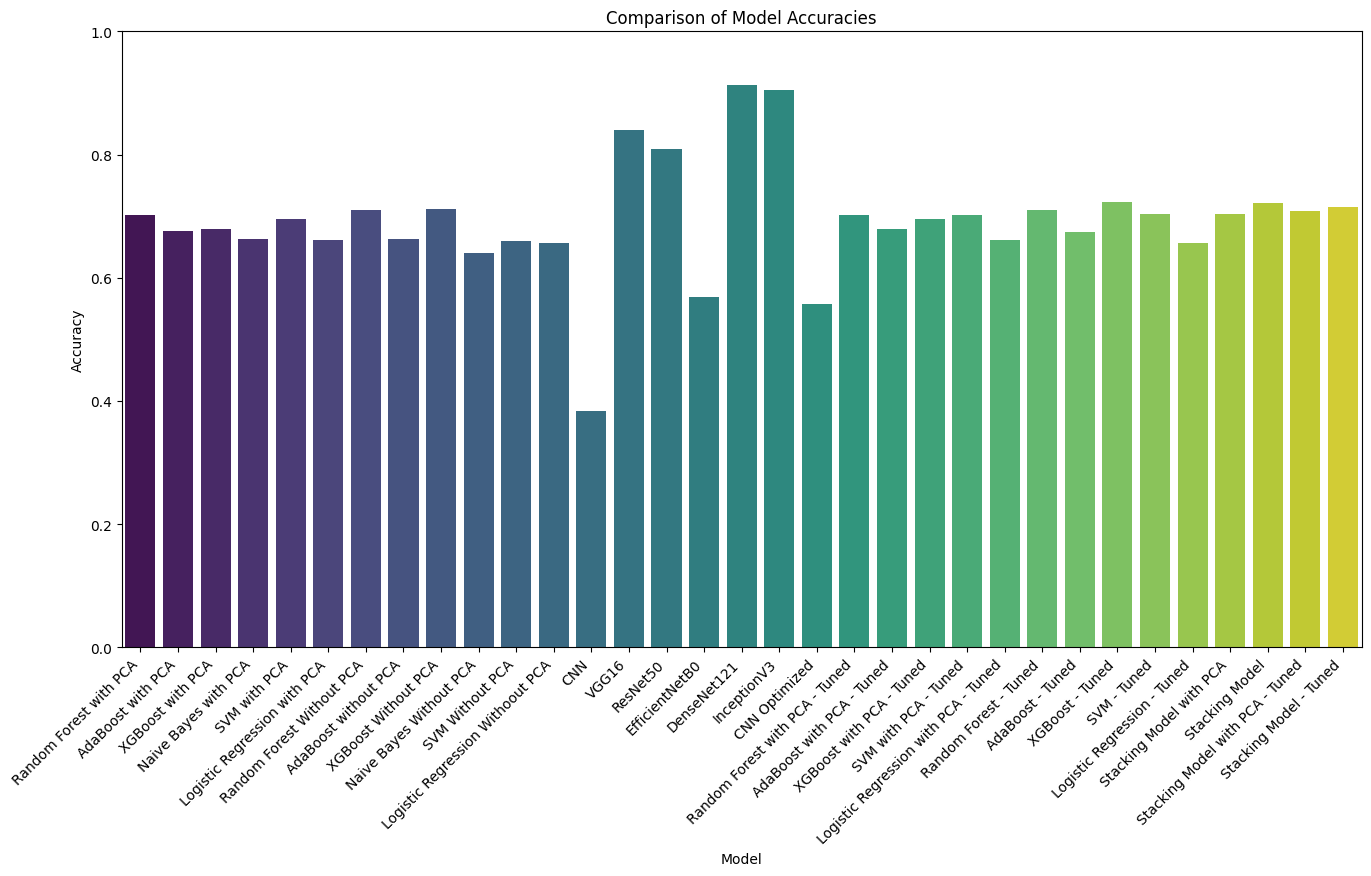

In [146]:
# Plotting the accuracies of all the models to compare their performance
plt.figure(figsize=(16, 8))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()

- The above chart compares the various accuracies of deep learning and traditional machine learning models and the findings reveal that deep learning especially the DenseNet121 model has the best performance.
- The findings also reveal that PCA does not necessarily significantly improve the performance models.

In [147]:
# Print the model accuracies for reference
print("Model Accuracies:")
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name}: {accuracy:.2f}")

Model Accuracies:
Random Forest with PCA: 0.70
AdaBoost with PCA: 0.68
XGBoost with PCA: 0.68
Naive Bayes with PCA: 0.66
SVM with PCA: 0.70
Logistic Regression with PCA: 0.66
Random Forest Without PCA: 0.71
AdaBoost without PCA: 0.66
XGBoost Without PCA: 0.71
Naive Bayes Without PCA: 0.64
SVM Without PCA: 0.66
Logistic Regression Withoout PCA: 0.66
CNN: 0.38
VGG16: 0.84
ResNet50: 0.81
EfficientNetB0: 0.57
DenseNet121: 0.91
InceptionV3: 0.90
CNN Optimized: 0.56
Random Forest with PCA - Tuned: 0.70
AdaBoost with PCA - Tuned: 0.68
XGBoost with PCA - Tuned: 0.69
SVM with PCA - Tuned: 0.70
Logistic Regression with PCA - Tuned: 0.66
Random Forest - Tuned: 0.71
AdaBoost - Tuned: 0.67
XGBoost - Tuned: 0.72
SVM - Tuned: 0.70
Logistic Regression - Tuned: 0.66
Stacking Model with PCA: 0.70
Stacking Model: 0.72
Stacking Model with PCA - Tuned: 0.71
Stacking Model - Tuned: 0.72


### COMPARATIVE ROC CURVE ANALYSIS

In [30]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define the paths to your saved models
model_paths = [
    
    'DenseNet121_transfer_learning_model.h5',
    'EfficientNetB0_transfer_learning_model.h5',
    'InceptionV3_transfer_learning_model.h5',
    'ResNet50_transfer_learning_model.h5',
    'VGG16_transfer_learning_model.h5'
]

# Load the models
models = [load_model(path) for path in model_paths]


In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc

# Prepare test data generator
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    test_directory,
    target_size=(150, 150),  # Adjust this based on your model's input size
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


Found 2513 images belonging to 2 classes.


79/79 [==============================] - 259s 3s/step


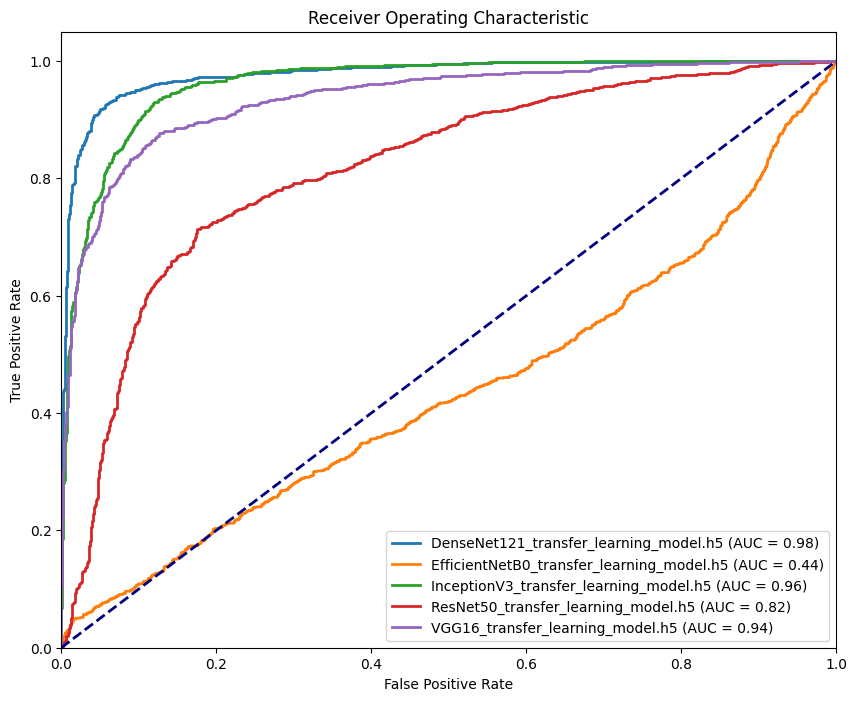

In [32]:
# Plotting the ROC Curves for different models
plt.figure(figsize=(10, 8))

for model, model_path in zip(models, model_paths):
    # Generate predictions
    predictions = model.predict(test_generator, steps=test_steps_per_epoch)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(test_generator.classes, predictions)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_path} (AUC = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


- The Receiver Operating Characteristics (ROC ) curve analysis presents the top best-performing models and findings indicate that the DenseNet121 model has the highest Area Under the Curve (AUC) value of 98% showing an excellent performance in differentiating between the two classes "Organic" and "Recyclable" wastes compared with other models. Though models like InceptionV3, VGG16, and ResNet50 perform extremely well by achieving high AUC values compared to other models although, their performance is slightly lower than DenseNet121.
  -Summarily, we can conclude that the Densenet121 model would be suitable for tasks requiring high classification accuracy.